In [1]:
#### Reference paper https://arxiv.org/abs/1808.08219




import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import scipy.optimize as optimize
from scipy.optimize import root_scalar
from adaptive_integrator import integrate
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})

import warnings
warnings.filterwarnings('ignore', 'The iteration is not making good progress')


π = np.pi
Ω_cdm = 0.85
G = 6.67e-11                # in units of m^3⋅kg^−1⋅s^−2
t_i = 2.358e5                # in units of seconds
t_eq = 1.5923e12            # in units of seconds
ρ_eq = 2.1548e-16          # in units of kg m^-3
M_solar = 1.989e30        # in units of kg
c = 3e8                 #in units of m/s
A = 1.495e11                 # Astronomical unit
pc = 3.085e16               # in unist of meter. 
yr = 3.154e7              # in units of seconds
a_eq = 2.9374e-4

hbar = 1.0545718e-34        # reduced Planck constant in unkits of J.s
eV = 1.60218e-19               #in units of J
eV_to_kg = 1.7826e-36             #in units of kg
m_FDM_eV = 1e-22     #in units of eV/c²
m_FDM = m_FDM_eV * eV_to_kg      # Mass of FDM boson in units of kg


 
def j_fdm(t, y, gamma):
    r, dydtau = y
    dydtau2 = (2 * gamma - gamma**2)/(4 * (r**3)) - (1/(r**2)) - r/(4 * (t**2))
    return [dydtau, dydtau2]


def j_cdm(t, y):
    r, dydtau = y
    dydtau2 =  - 1/(r**2) - r/(4 * (t**2))
    return [dydtau, dydtau2]


# Full analytic turnaround radius
def r_turnaround_full(tau, gamma): 
    def expression(y_ta):
        return y_ta**4 - 4 * y_ta * (tau**2) + (2 * gamma - gamma**2) * (tau**2)
    factor = 0.635 * (1 + 0.01 * np.log10(1 + gamma))
    #print(factor)
    r_ta_initial = factor * (8 * (tau**2))**(1/3)
    sol = optimize.fsolve(expression, r_ta_initial, xtol=1e-10)[0]
    return sol





# Event function for maximum (dy/dtau = 0)
def event_y_max(t, y, *args):
    return y[1]  # Detect when velocity (dy/dtau) is zero
event_y_max.terminal = False  # Do not stop integration here
event_y_max.direction = -1    # Detect decreasing slope (peak reached)
# Event function for minimum (dy/dtau = 0 after y_max)
def event_y_min(t, y, *args):
    return y[1]  # Detect when velocity (dy/dtau) is zero
event_y_min.terminal = True   # Stop integration here
event_y_min.direction = 1     # Detect increasing slope (trough reached)




def y_fdm(gamma):
    solutions = []
    turnaround_points = []
    for y_i in yi_values:
        v_i = y_i / (2 * tau_i)
        y0 = [y_i, v_i]
        tau_arr = np.geomspace(tau_i, tau_f, 10000)
        sol = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), 
                        method='RK45', t_eval=tau_arr, 
                        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])
        solutions.append((sol.t, sol.y[0], y_i))
        if sol.t_events[0].size > 0:
            tau_ta = sol.t_events[0][0]
            y_ta = sol.y_events[0][0][0]
            turnaround_points.append((tau_ta, y_ta, y_i))  
    return solutions, turnaround_points

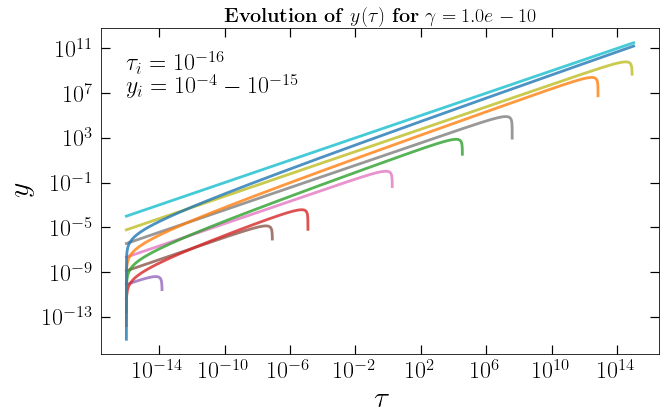

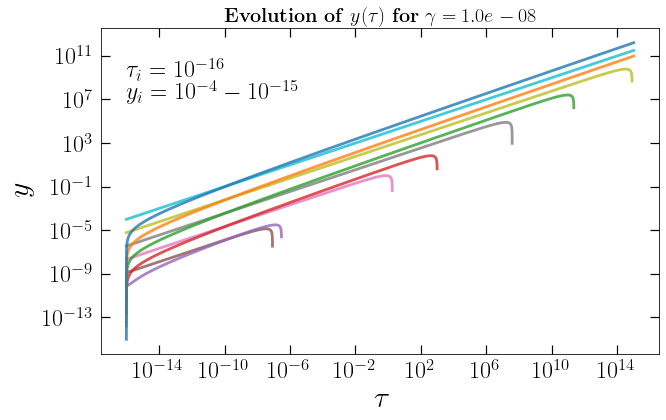

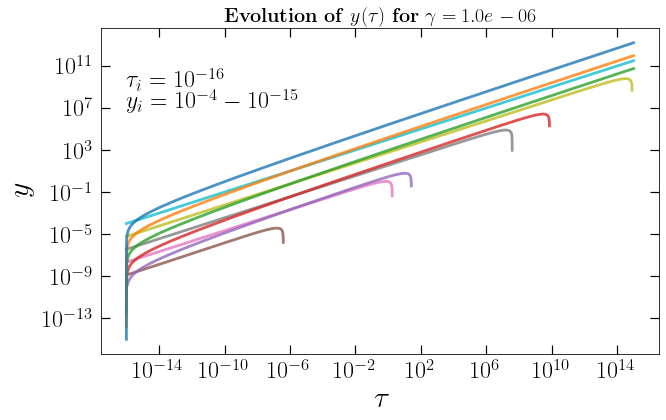

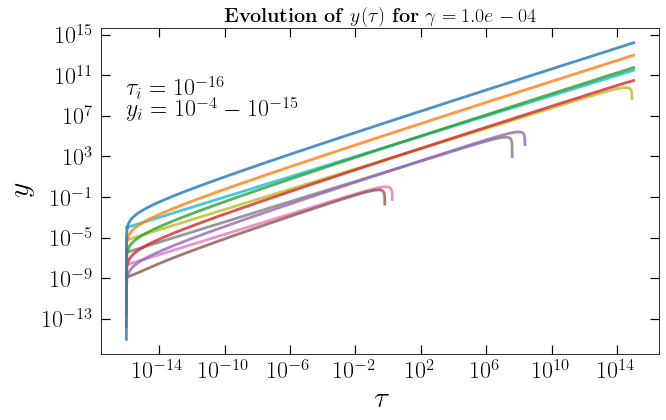

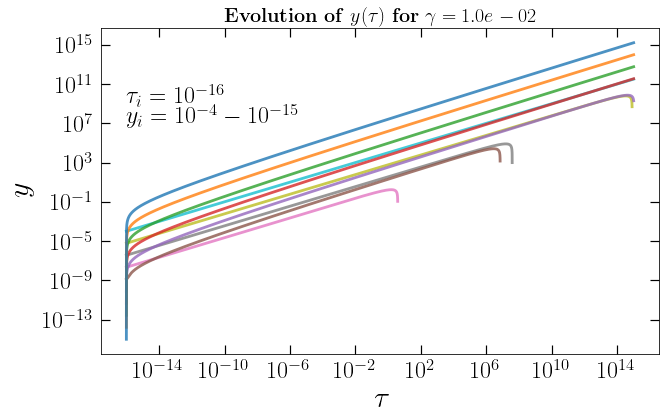

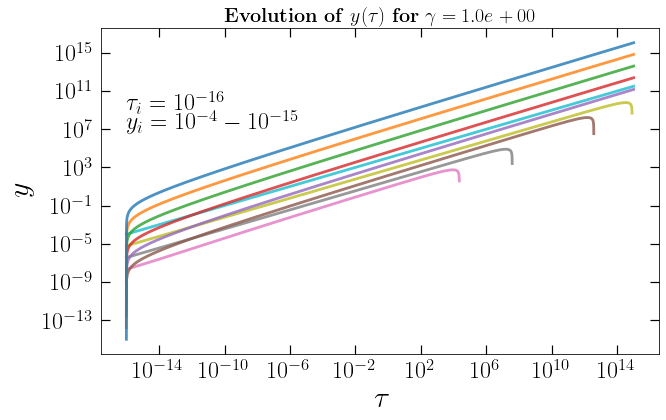

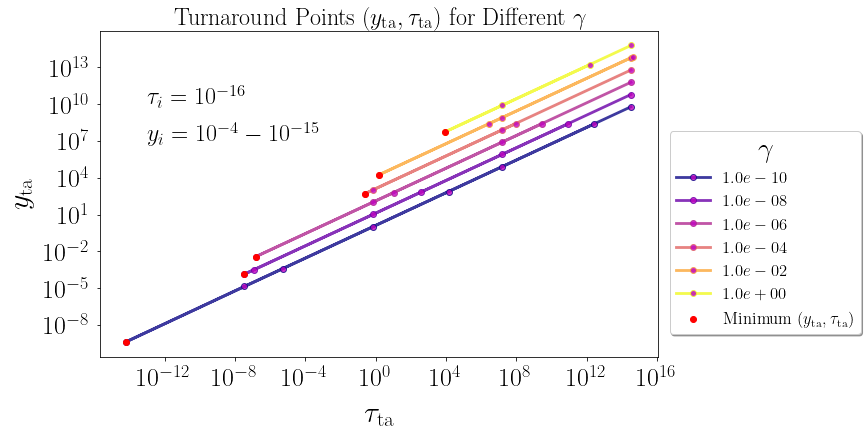

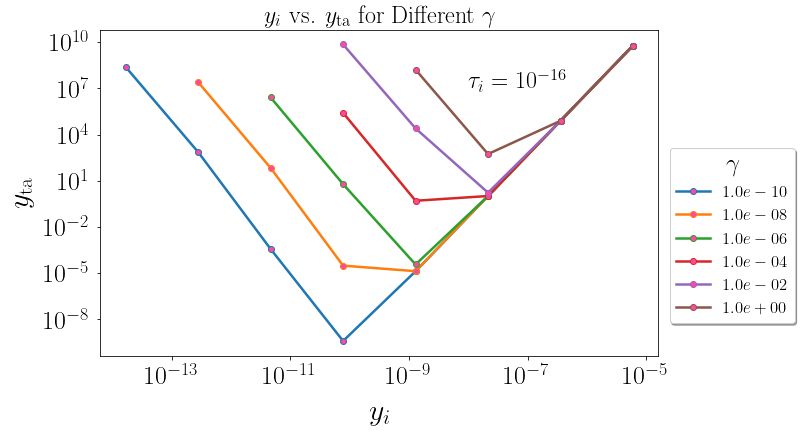

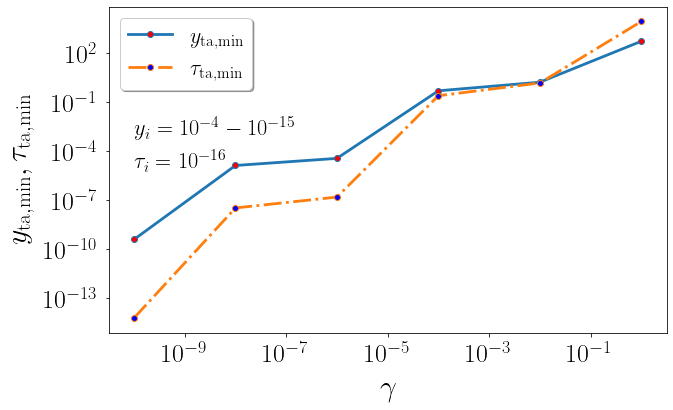

Minimum values of the turnraound points for each gamma :-
Gamma: 1.0e-10, Y_i: 7.7426e-11, Tau_ta_numerical: 6.2100e-15, Y_ta_numerical: 4.0057e-10, Y_ta_analytical: 5.1848e-10
Gamma: 1.0e-08, Y_i: 1.2915e-09, Tau_ta_numerical: 3.4184e-08, Y_ta_numerical: 1.3644e-05, Y_ta_analytical: 1.6718e-05
Gamma: 1.0e-06, Y_i: 1.2915e-09, Tau_ta_numerical: 1.5814e-07, Y_ta_numerical: 3.7167e-05, Y_ta_analytical: 4.6252e-05
Gamma: 1.0e-04, Y_i: 1.2915e-09, Tau_ta_numerical: 2.5585e-01, Y_ta_numerical: 5.1205e-01, Y_ta_analytical: 6.3974e-01
Gamma: 1.0e-02, Y_i: 2.1544e-08, Tau_ta_numerical: 1.5426e+00, Y_ta_numerical: 1.7205e+00, Y_ta_analytical: 2.1177e+00
Gamma: 1.0e+00, Y_i: 2.1544e-08, Tau_ta_numerical: 9.0309e+03, Y_ta_numerical: 5.5363e+02, Y_ta_analytical: 6.8832e+02


In [2]:
# Now, we want to verify that for a given value of gamma,
# whether the minimum values of yta_numerical and tau_ta_numerical are properly 
# identified or not.
# This will verify the validity of y_ta_min vs y_i plots.



gamma_values = np.geomspace(1e-10, 1, 6) 
yi_values = np.geomspace(1e-4, 1e-15, 10)  
tau_i, tau_f = 1e-16, 1e15 
colors = ['C9','C8','C7','C6', 'C5', 'C4', 'C3', 'C2', 'C1', 'C0']  



gamma_results = {gamma: y_fdm(gamma) for gamma in gamma_values}
#min_turnaround_pts = [(gamma, *min(gamma_results[gamma][1], key=lambda x: x[1])) 
                      #for gamma in gamma_values]
# Find minimum turnaround points
min_turnaround_pts = []
for gamma in gamma_values:
    _, turnaround_points = gamma_results[gamma]
    if turnaround_points:  
        all_y_ta = [yta for _, yta, _ in turnaround_points]  # Extract all turnaround points
        min_idx = np.argmin(all_y_ta)  # Find index of smallest y_ta
        min_tau_ta, min_y_ta, min_yi_ta = turnaround_points[min_idx]
        min_turnaround_pts.append((gamma, min_yi_ta, min_tau_ta, min_y_ta))

        
gamma_colors = plt.cm.viridis(np.linspace(0, 1, len(gamma_values)))
turnaround_colors = plt.cm.plasma(np.linspace(0, 1, len(gamma_values)))  



#plotting y vs tau for different values of gamma, each with different values of y_i
for i, (gamma, (solutions, _)) in enumerate(gamma_results.items()):
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    plt.rc('lines', linewidth = 2.8)
    plt.rcParams['font.family'] = 'serif'
    plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
    plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')

    for j, ((tau_vals, y_vals, y_i), color) in enumerate(zip(solutions, colors * (len(solutions) // len(colors) + 1))):
        ax1.loglog(tau_vals, y_vals, color=color, alpha=0.8, label=f"${y_i:.1e}$")
    
    plt.text(tau_i, 1e9, r'$\tau_i = 10^{-16}$', fontsize=24)
    plt.text(tau_i, 1e7, r'$y_i = 10^{-4} - 10^{-15}$', fontsize=24)
    ax1.tick_params(axis='x', pad=6.9)
    ax1.tick_params(axis='y', pad=6.9)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.xlabel(r'$\tau$', fontsize=30)
    plt.ylabel(r'$y$', fontsize=30, labelpad=9)
    ax1.set_title(rf'$\mathbf{{Evolution\ of\ }} y(\tau) \mathbf{{\ for\ }} \gamma={gamma:.1e}$', fontsize=20)
    #ax1.legend(prop={'size':13.7}, loc=(1.02, 0.1), shadow=True, title='$y_{i}$', title_fontsize=26,
              # facecolor='white', fontsize=12)
    plt.savefig(f"yvstau3_gamma_{gamma:.1e}.pdf",  bbox_inches='tight')
    plt.show()



    
    
#plotting (y_ta, tau_ta) points for different values of gamma (each with different values of y_i)
fig2, ax2 = plt.subplots(figsize=(10, 6))
for i, (gamma, (_, turnaround_points)) in enumerate(gamma_results.items()): 
    tau_ta, y_ta, yi_ta = zip(*turnaround_points)  
    y_ta_scaled = [y * 10**i for y in y_ta] 
    ax2.loglog(tau_ta, y_ta_scaled, color=turnaround_colors[i], label=f"${gamma:.1e}$", marker='o', markersize=6, markerfacecolor='m', alpha=0.8)

    
    
#gamma_arr,  min_tau_arr, min_y_arr, min_yi_arr = zip(*min_turnaround_pts)
gamma_arr, min_yi_arr, min_tau_arr, min_y_arr = zip(*min_turnaround_pts)
min_y_arr_scaled = [y * 10**i for i, y in enumerate(min_y_arr)]
ax2.scatter(min_tau_arr, min_y_arr_scaled, color='r', zorder=10, label="Minimum $( y_\\mathrm{ta}, \\tau_\\mathrm{ta})$")

plt.text(1e-13, 1e7, '$y_i = 10^{-4} - 10^{-15}$', fontsize=24)
plt.text(1e-13, 1e10, r'$\tau_i = 10^{-16}$', fontsize=24)
ax2.tick_params(axis='x', pad=6.9)
ax2.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
ax2.set_xlabel(r'$\tau_\mathrm{ta}$', fontsize=30, labelpad=10)
ax2.set_ylabel(r'$y_\mathrm{ta}$', fontsize=30, labelpad=10)
ax2.set_title(r'Turnaround Points $(y_\mathrm{ta}, \tau_\mathrm{ta})$ for Different $\gamma$', fontsize=24)
ax2.legend(prop={'size':16.7}, loc=(1.02, 0.07), shadow=True, title=r'$\gamma$', title_fontsize=28,
           facecolor='white', fontsize=12)
plt.savefig("yta_vs_tauta3.pdf", bbox_inches='tight')
plt.show()



#plotting (y_ta, y_i) points for different values of gamma 
fig3, ax3 = plt.subplots(figsize=(10, 6))
for i, (gamma, (_, turnaround_points)) in enumerate(gamma_results.items()):
    tau_ta , y_ta,  yi_ta = zip(*turnaround_points)
    ax3.loglog(yi_ta, y_ta, marker='o', markersize=6, markerfacecolor='#fd49a0', linestyle='-', linewidth=2.5, label=f"${gamma:.1e}$")

    
#plt.text(1e-8, 1e9, '$y_i = 10^{-4} - 10^{-15}$', fontsize=24)
plt.text(1e-8, 1e7, r'$\tau_i = 10^{-16}$', fontsize=24)
ax3.tick_params(axis='x', pad=6.9)
ax3.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
ax3.set_xlabel(r'$y_i$', fontsize=30, labelpad=10)
ax3.set_ylabel(r'$y_\mathrm{ta}$', fontsize=30, labelpad=10)
ax3.set_title(r'$y_i$ vs. $y_\mathrm{ta}$ for Different $\gamma$', fontsize=24)
ax3.legend(prop={'size':16.7}, loc=(1.02, 0.1), shadow=True, title=r'$\gamma$', title_fontsize=25,
           facecolor='white', fontsize=12)
plt.savefig("yi_vs_yta3.pdf", bbox_inches='tight')
plt.show()



# y_ta_min, tau_ta_min vs gamma
fig4, ax4 = plt.subplots(figsize=(10, 6))
#gamma_arr, min_tau_arr, min_y_arr,  min_yi_arr = zip(*min_turnaround_pts)
gamma_arr, min_yi_arr, min_tau_arr, min_y_arr = zip(*min_turnaround_pts)

ax4.loglog(gamma_arr, min_y_arr, marker='o', markersize=6, markerfacecolor='r',ls = '-')
ax4.loglog(gamma_arr, min_tau_arr,  marker='o', markersize=6, markerfacecolor='b', ls = '-.')

plt.text(1e-10, 1e-3, '$y_i = 10^{-4} - 10^{-15}$', fontsize=22.5)
plt.text(1e-10, 1e-5, r'$\tau_i = 10^{-16}$', fontsize=22.5)



ax4.tick_params(axis='x', pad=6.9)
ax4.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
ax4.set_xlabel('$\gamma$', fontsize=30, labelpad=10)
ax4.set_ylabel(r'$y_\mathrm{ta, min},  \tau_\mathrm{ta, min}$', fontsize=30, labelpad=10)
ax4.legend([r"$y_\mathrm{ta, min}$", r"$\tau_\mathrm{ta, min}$"], prop={'size':22}, loc='upper left', shadow=True,  title_fontsize=18,
           facecolor='white', fontsize=12)

plt.savefig("ytamin_vs_gamma3.pdf", bbox_inches='tight')
plt.show()

gamma_arr, min_yi_arr, min_tau_arr, min_y_arr = zip(*min_turnaround_pts)
yta_analytical_arr = np.zeros(len(gamma_arr))
for i, (gamma, min_tau) in enumerate(zip(gamma_arr, min_tau_arr)):
    yta_analytical_arr[i] = r_turnaround_full(min_tau, gamma)

min_turnaround_pts = list(zip(gamma_arr, min_yi_arr, min_tau_arr, min_y_arr, yta_analytical_arr))
print('Minimum values of the turnraound points for each gamma :-')
for gamma, min_yi, min_tau, min_y, y_ta_ana in min_turnaround_pts:
    print(f"Gamma: {gamma:.1e}, Y_i: {min_yi:.4e}, Tau_ta_numerical: {min_tau:.4e}, Y_ta_numerical: {min_y:.4e}, Y_ta_analytical: {y_ta_ana:.4e}")

In [ ]:
# plots of y vs tau with 
# y_i-spacings = [0.99 y_i_min_ref , yi_min_ref, 1.01 yi_min_ref]

y_i = 7.6652e-11 , tau_ta_numerical = 5.9888e-15 , yta_numerical = 3.9035e-10 , yta_analytic = 5.0564e-10
y_i = 7.6845e-11 , tau_ta_numerical = 6.0431e-15 , yta_numerical = 3.9287e-10 , yta_analytic = 5.0881e-10
y_i = 7.7038e-11 , tau_ta_numerical = 6.0981e-15 , yta_numerical = 3.9541e-10 , yta_analytic = 5.1200e-10
y_i = 7.7232e-11 , tau_ta_numerical = 6.1537e-15 , yta_numerical = 3.9798e-10 , yta_analytic = 5.1523e-10
y_i = 7.7426e-11 , tau_ta_numerical = 6.2099e-15 , yta_numerical = 4.0056e-10 , yta_analytic = 5.1848e-10
y_i = 7.7580e-11 , tau_ta_numerical = 6.2549e-15 , yta_numerical = 4.0262e-10 , yta_analytic = 5.2107e-10
y_i = 7.7735e-11 , tau_ta_numerical = 6.2934e-15 , yta_numerical = 4.0470e-10 , yta_analytic = 5.2329e-10
y_i = 7.7890e-11 , tau_ta_numerical = 6.3412e-15 , yta_numerical = 4.0679e-10 , yta_analytic = 5.2603e-10
y_i = 7.8045e-11 , tau_ta_numerical = 6.3841e-15 , yta_numerical = 4.0889e-10 , yta_analytic = 5.2849e-10
y_i = 7.8200e-11 , tau_ta_numerical = 6.4309e-

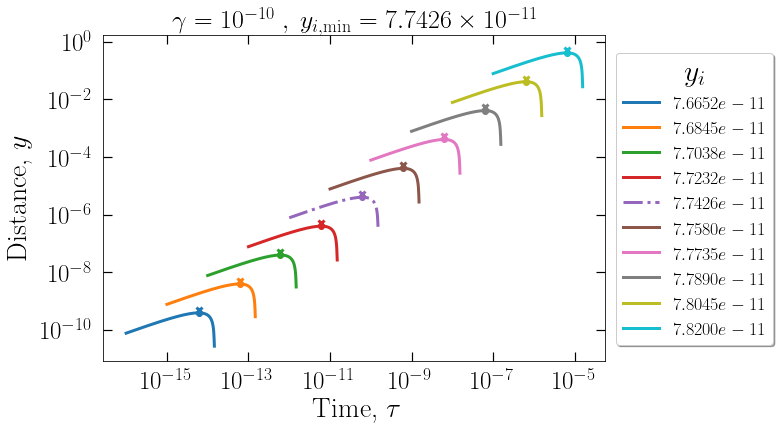

In [6]:
gamma = 1e-10
y_i_ref =7.7426e-11
tau_i, tau_f = 1e-16, 1e15
gamma_values = np.geomspace(1e-10, 1, 5)

 
#yi_arr = np.array([0.9*y_i_ref, 0.95*y_i_ref, 0.99*y_i_ref,  
                   #y_i_ref, 1.01*y_i_ref, 1.05*y_i_ref, 1.1*y_i_ref])

    
yi_1 = 0.99*y_i_ref
yi_2 = 1.01*y_i_ref

yi_arr1 = np.geomspace(yi_1, y_i_ref, 5)

yi_arr2 = np.geomspace(y_i_ref, yi_2, 6)

sliced_yi_arr2 = yi_arr2[1:6]
#print(sliced_yi_arr2)
yi_arr = np.append(yi_arr1, sliced_yi_arr2)

fig, ax = plt.subplots(1, figsize = (9, 6))
plt.rc('lines', linewidth = 3)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')






colors = [ 'C0','C1','C2','C3','C4','C5', 'C6', 'C7', 'C8', 'C9']

marker_handles = []
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])

    
    if i == 4:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$', ls ='-.')
    else:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$')

    
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        yta_analytic = r_turnaround_full(tauta_numerical, gamma)
        print( "y_i =", '%0.4e'%y_i , ",",  "tau_ta_numerical =", '%0.4e'%tauta_numerical, ",", "yta_numerical =", '%0.4e'%yta_numerical, ",", "yta_analytic =", '%0.4e'%yta_analytic)
            
        yta_numerical_marker = ax.scatter(tauta_numerical* (10**i), yta_numerical* (10**i),color=color, zorder=1  )
        yta_analytic_marker = ax.scatter(tauta_numerical* (10**i), yta_analytic* (10**i), color=color,  marker='x',  zorder=9)
        if i == 0:
            marker_handles.append((yta_numerical_marker, "Numerical "))
            marker_handles.append((yta_analytic_marker, "Analytic"))

if len(marker_handles) == 2:  
    legend1 = plt.legend(
        handles=[marker_handles[0][0], marker_handles[1][0]],
        labels=[marker_handles[0][1], marker_handles[1][1]],prop={'size':16.2},
        loc=(1.02, 0.58), title=r'$y_\mathrm{ta}$', title_fontsize= 29, fontsize=12)
    #ax.add_artist(legend1)


lines = ax.get_lines()
legend2 = plt.legend( prop={'size':18}, 
                     loc=(1.02, 0.05), shadow=True, title='$y_{i}$', title_fontsize= 30,
    facecolor='white', fontsize=12)


ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


#plt.text(tau_i, 1e-4, r'$\gamma = 3.6\times 10^{-5}$', fontsize = 25)
#plt.text(tau_i, 1e-6, r'$\tau_i = 10^{-28}$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28, labelpad=9)
plt.title(r'$\gamma = 10^{-10}\; , \; y_{i, \mathrm{min}} =  7.7426 \times 10^{-11}$', fontsize= 26)
plt.savefig('yta_min1.pdf', bbox_inches='tight')

plt.show()

y_i = 1.2786e-09 , tau_ta_numerical = 3.2198e-08 , yta_numerical = 1.3110e-05 , yta_analytic = 1.6064e-05
y_i = 1.2818e-09 , tau_ta_numerical = 3.2682e-08 , yta_numerical = 1.3241e-05 , yta_analytic = 1.6225e-05
y_i = 1.2850e-09 , tau_ta_numerical = 3.3173e-08 , yta_numerical = 1.3374e-05 , yta_analytic = 1.6387e-05
y_i = 1.2883e-09 , tau_ta_numerical = 3.3671e-08 , yta_numerical = 1.3507e-05 , yta_analytic = 1.6550e-05
y_i = 1.2915e-09 , tau_ta_numerical = 3.4176e-08 , yta_numerical = 1.3642e-05 , yta_analytic = 1.6716e-05
y_i = 1.2941e-09 , tau_ta_numerical = 3.4582e-08 , yta_numerical = 1.3750e-05 , yta_analytic = 1.6848e-05
y_i = 1.2967e-09 , tau_ta_numerical = 3.4993e-08 , yta_numerical = 1.3859e-05 , yta_analytic = 1.6981e-05
y_i = 1.2992e-09 , tau_ta_numerical = 3.5409e-08 , yta_numerical = 1.3968e-05 , yta_analytic = 1.7115e-05
y_i = 1.3018e-09 , tau_ta_numerical = 3.5830e-08 , yta_numerical = 1.4079e-05 , yta_analytic = 1.7251e-05
y_i = 1.3044e-09 , tau_ta_numerical = 3.6255e-

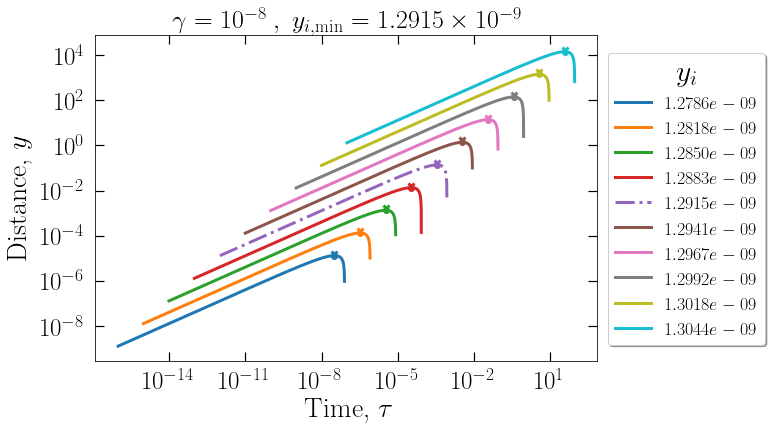

In [7]:
gamma = 1e-8
y_i_ref = 1.2915e-09
tau_i, tau_f = 1e-16, 1e15
gamma_values = np.geomspace(1e-10, 1, 5)

 
#yi_arr = np.array([0.9*y_i_ref, 0.95*y_i_ref, 0.99*y_i_ref,  
                   #y_i_ref, 1.01*y_i_ref, 1.05*y_i_ref, 1.1*y_i_ref])

    
yi_1 = 0.99*y_i_ref
yi_2 = 1.01*y_i_ref

yi_arr1 = np.geomspace(yi_1, y_i_ref, 5)

yi_arr2 = np.geomspace(y_i_ref, yi_2, 6)

sliced_yi_arr2 = yi_arr2[1:6]
#print(sliced_yi_arr2)
yi_arr = np.append(yi_arr1, sliced_yi_arr2)

fig, ax = plt.subplots(1, figsize = (9, 6))
plt.rc('lines', linewidth = 3)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')






colors = [ 'C0','C1','C2','C3','C4','C5', 'C6', 'C7', 'C8', 'C9']

marker_handles = []
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])

    
    if i == 4:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$', ls ='-.')
    else:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$')

    
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        yta_analytic = r_turnaround_full(tauta_numerical, gamma)
        print( "y_i =", '%0.4e'%y_i , ",",  "tau_ta_numerical =", '%0.4e'%tauta_numerical, ",", "yta_numerical =", '%0.4e'%yta_numerical, ",", "yta_analytic =", '%0.4e'%yta_analytic)
            
        yta_numerical_marker = ax.scatter(tauta_numerical* (10**i), yta_numerical* (10**i),color=color, zorder=1  )
        yta_analytic_marker = ax.scatter(tauta_numerical* (10**i), yta_analytic* (10**i), color=color,  marker='x',  zorder=9)
        if i == 0:
            marker_handles.append((yta_numerical_marker, "Numerical "))
            marker_handles.append((yta_analytic_marker, "Analytic"))

if len(marker_handles) == 2:  
    legend1 = plt.legend(
        handles=[marker_handles[0][0], marker_handles[1][0]],
        labels=[marker_handles[0][1], marker_handles[1][1]],prop={'size':16.2},
        loc=(1.02, 0.58), title=r'$y_\mathrm{ta}$', title_fontsize= 29, fontsize=12)
    #ax.add_artist(legend1)


lines = ax.get_lines()
legend2 = plt.legend( prop={'size':18}, 
                     loc=(1.02, 0.05), shadow=True, title='$y_{i}$', title_fontsize= 30,
    facecolor='white', fontsize=12)


ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


#plt.text(tau_i, 1e-4, r'$\gamma = 3.6\times 10^{-5}$', fontsize = 25)
#plt.text(tau_i, 1e-6, r'$\tau_i = 10^{-28}$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28, labelpad=9)
plt.title(r'$\gamma = 10^{-8}\; , \; y_{i, \mathrm{min}} =  1.2915 \times 10^{-9}$', fontsize= 26)
plt.savefig('yta_min2.pdf', bbox_inches='tight')

plt.show()

y_i = 1.2786e-09 , tau_ta_numerical = 1.5593e-07 , yta_numerical = 3.6807e-05 , yta_analytic = 4.5819e-05
y_i = 1.2818e-09 , tau_ta_numerical = 1.5646e-07 , yta_numerical = 3.6893e-05 , yta_analytic = 4.5923e-05
y_i = 1.2850e-09 , tau_ta_numerical = 1.5700e-07 , yta_numerical = 3.6982e-05 , yta_analytic = 4.6030e-05
y_i = 1.2883e-09 , tau_ta_numerical = 1.5756e-07 , yta_numerical = 3.7073e-05 , yta_analytic = 4.6139e-05
y_i = 1.2915e-09 , tau_ta_numerical = 1.5813e-07 , yta_numerical = 3.7166e-05 , yta_analytic = 4.6250e-05
y_i = 1.2941e-09 , tau_ta_numerical = 1.5859e-07 , yta_numerical = 3.7241e-05 , yta_analytic = 4.6341e-05
y_i = 1.2967e-09 , tau_ta_numerical = 1.5906e-07 , yta_numerical = 3.7317e-05 , yta_analytic = 4.6432e-05
y_i = 1.2992e-09 , tau_ta_numerical = 1.5953e-07 , yta_numerical = 3.7395e-05 , yta_analytic = 4.6526e-05
y_i = 1.3018e-09 , tau_ta_numerical = 1.6002e-07 , yta_numerical = 3.7473e-05 , yta_analytic = 4.6620e-05
y_i = 1.3044e-09 , tau_ta_numerical = 1.6051e-

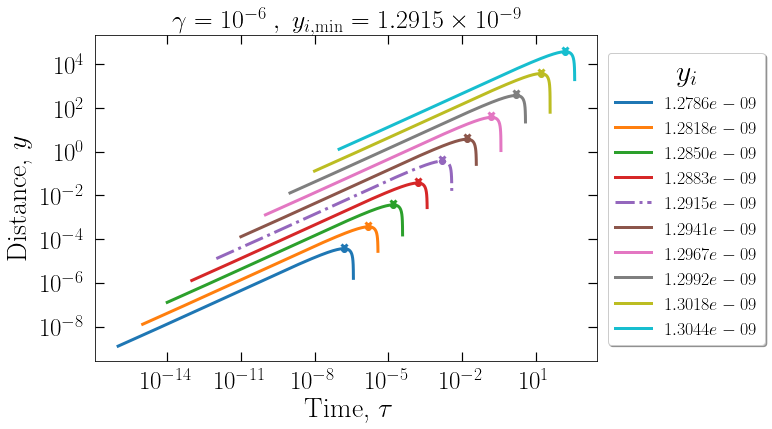

In [8]:
gamma = 1e-6
y_i_ref = 1.2915e-09
tau_i, tau_f = 1e-16, 1e15
gamma_values = np.geomspace(1e-10, 1, 5)

 
#yi_arr = np.array([0.9*y_i_ref, 0.95*y_i_ref, 0.99*y_i_ref,  
                   #y_i_ref, 1.01*y_i_ref, 1.05*y_i_ref, 1.1*y_i_ref])

    
yi_1 = 0.99*y_i_ref
yi_2 = 1.01*y_i_ref

yi_arr1 = np.geomspace(yi_1, y_i_ref, 5)

yi_arr2 = np.geomspace(y_i_ref, yi_2, 6)

sliced_yi_arr2 = yi_arr2[1:6]
#print(sliced_yi_arr2)
yi_arr = np.append(yi_arr1, sliced_yi_arr2)

fig, ax = plt.subplots(1, figsize = (9, 6))
plt.rc('lines', linewidth = 3)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')






colors = [ 'C0','C1','C2','C3','C4','C5', 'C6', 'C7', 'C8', 'C9']
marker_handles = []
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])

    
    if i == 4:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$', ls ='-.')
    else:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$')

    
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        yta_analytic = r_turnaround_full(tauta_numerical, gamma)
        print( "y_i =", '%0.4e'%y_i , ",",  "tau_ta_numerical =", '%0.4e'%tauta_numerical, ",", "yta_numerical =", '%0.4e'%yta_numerical, ",", "yta_analytic =", '%0.4e'%yta_analytic)
            
        yta_numerical_marker = ax.scatter(tauta_numerical* (10**i), yta_numerical* (10**i),color=color, zorder=1  )
        yta_analytic_marker = ax.scatter(tauta_numerical* (10**i), yta_analytic* (10**i), color=color,  marker='x',  zorder=9)
        if i == 0:
            marker_handles.append((yta_numerical_marker, "Numerical "))
            marker_handles.append((yta_analytic_marker, "Analytic"))

if len(marker_handles) == 2:  
    legend1 = plt.legend(
        handles=[marker_handles[0][0], marker_handles[1][0]],
        labels=[marker_handles[0][1], marker_handles[1][1]],prop={'size':16.2},
        loc=(1.02, 0.58), title=r'$y_\mathrm{ta}$', title_fontsize= 29, fontsize=12)
    #ax.add_artist(legend1)


lines = ax.get_lines()
legend2 = plt.legend( prop={'size':18}, 
                     loc=(1.02, 0.05), shadow=True, title='$y_{i}$', title_fontsize= 30,
    facecolor='white', fontsize=12)


ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


#plt.text(tau_i, 1e-4, r'$\gamma = 3.6\times 10^{-5}$', fontsize = 25)
#plt.text(tau_i, 1e-6, r'$\tau_i = 10^{-28}$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28, labelpad=9)
plt.title(r'$\gamma = 10^{-6}\; , \; y_{i, \mathrm{min}} =  1.2915 \times 10^{-9}$', fontsize= 26)
plt.savefig('yta_min3.pdf', bbox_inches='tight')

plt.show()

y_i = 1.2786e-09 , tau_ta_numerical = 2.7205e-01 , yta_numerical = 5.3347e-01 , yta_analytic = 6.6646e-01
y_i = 1.2818e-09 , tau_ta_numerical = 2.6857e-01 , yta_numerical = 5.2889e-01 , yta_analytic = 6.6076e-01
y_i = 1.2850e-09 , tau_ta_numerical = 2.6454e-01 , yta_numerical = 5.2359e-01 , yta_analytic = 6.5415e-01
y_i = 1.2883e-09 , tau_ta_numerical = 2.6032e-01 , yta_numerical = 5.1800e-01 , yta_analytic = 6.4717e-01
y_i = 1.2915e-09 , tau_ta_numerical = 2.5592e-01 , yta_numerical = 5.1215e-01 , yta_analytic = 6.3985e-01
y_i = 1.2941e-09 , tau_ta_numerical = 2.5126e-01 , yta_numerical = 5.0591e-01 , yta_analytic = 6.3207e-01
y_i = 1.2967e-09 , tau_ta_numerical = 2.4903e-01 , yta_numerical = 5.0290e-01 , yta_analytic = 6.2831e-01
y_i = 1.2992e-09 , tau_ta_numerical = 2.4595e-01 , yta_numerical = 4.9875e-01 , yta_analytic = 6.2312e-01
y_i = 1.3018e-09 , tau_ta_numerical = 2.4271e-01 , yta_numerical = 4.9435e-01 , yta_analytic = 6.1763e-01
y_i = 1.3044e-09 , tau_ta_numerical = 2.3945e-

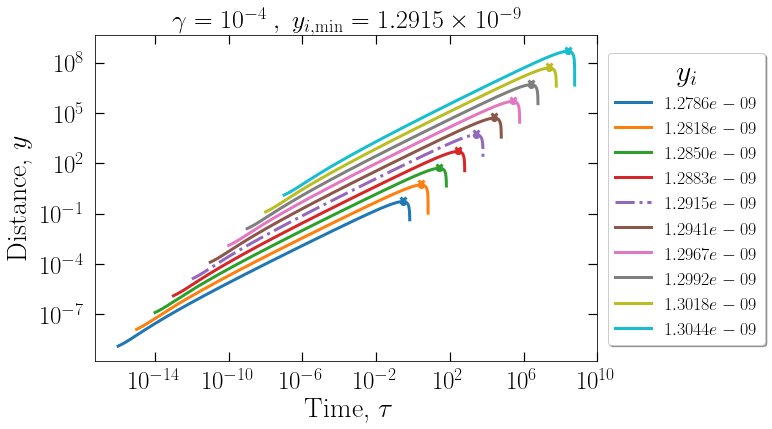

In [9]:
gamma = 1e-4
y_i_ref = 1.2915e-09
tau_i, tau_f = 1e-16, 1e15
gamma_values = np.geomspace(1e-10, 1, 5)

 
#yi_arr = np.array([0.9*y_i_ref, 0.95*y_i_ref, 0.99*y_i_ref,  
                   #y_i_ref, 1.01*y_i_ref, 1.05*y_i_ref, 1.1*y_i_ref])

    
yi_1 = 0.99*y_i_ref
yi_2 = 1.01*y_i_ref

yi_arr1 = np.geomspace(yi_1, y_i_ref, 5)

yi_arr2 = np.geomspace(y_i_ref, yi_2, 6)

sliced_yi_arr2 = yi_arr2[1:6]
#print(sliced_yi_arr2)
yi_arr = np.append(yi_arr1, sliced_yi_arr2)

fig, ax = plt.subplots(1, figsize = (9, 6))
plt.rc('lines', linewidth = 3)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')





colors = [ 'C0','C1','C2','C3','C4','C5', 'C6', 'C7', 'C8', 'C9']
marker_handles = []
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])

    
    if i == 4:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$', ls ='-.')
    else:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$')

    
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        yta_analytic = r_turnaround_full(tauta_numerical, gamma)
        print( "y_i =", '%0.4e'%y_i , ",",  "tau_ta_numerical =", '%0.4e'%tauta_numerical, ",", "yta_numerical =", '%0.4e'%yta_numerical, ",", "yta_analytic =", '%0.4e'%yta_analytic)
            
        yta_numerical_marker = ax.scatter(tauta_numerical* (10**i), yta_numerical* (10**i),color=color, zorder=1  )
        yta_analytic_marker = ax.scatter(tauta_numerical* (10**i), yta_analytic* (10**i), color=color,  marker='x',  zorder=9)
        if i == 0:
            marker_handles.append((yta_numerical_marker, "Numerical "))
            marker_handles.append((yta_analytic_marker, "Analytic"))

if len(marker_handles) == 2:  
    legend1 = plt.legend(
        handles=[marker_handles[0][0], marker_handles[1][0]],
        labels=[marker_handles[0][1], marker_handles[1][1]],prop={'size':16.2},
        loc=(1.02, 0.58), title=r'$y_\mathrm{ta}$', title_fontsize= 29, fontsize=12)
    #ax.add_artist(legend1)


lines = ax.get_lines()
legend2 = plt.legend( prop={'size':18}, 
                     loc=(1.02, 0.05), shadow=True, title='$y_{i}$', title_fontsize= 30,
    facecolor='white', fontsize=12)


ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


#plt.text(tau_i, 1e-4, r'$\gamma = 3.6\times 10^{-5}$', fontsize = 25)
#plt.text(tau_i, 1e-6, r'$\tau_i = 10^{-28}$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28, labelpad=9)
plt.title(r'$\gamma = 10^{-4}\; , \; y_{i, \mathrm{min}} =  1.2915 \times 10^{-9}$', fontsize= 26)
plt.savefig('yta_min4.pdf', bbox_inches='tight')

plt.show()

y_i = 2.1329e-08 , tau_ta_numerical = 1.4909e+00 , yta_numerical = 1.6816e+00 , yta_analytic = 2.0700e+00
y_i = 2.1382e-08 , tau_ta_numerical = 1.5036e+00 , yta_numerical = 1.6911e+00 , yta_analytic = 2.0817e+00
y_i = 2.1436e-08 , tau_ta_numerical = 1.5164e+00 , yta_numerical = 1.7008e+00 , yta_analytic = 2.0935e+00
y_i = 2.1490e-08 , tau_ta_numerical = 1.5294e+00 , yta_numerical = 1.7105e+00 , yta_analytic = 2.1055e+00
y_i = 2.1544e-08 , tau_ta_numerical = 1.5426e+00 , yta_numerical = 1.7204e+00 , yta_analytic = 2.1176e+00
y_i = 2.1587e-08 , tau_ta_numerical = 1.5531e+00 , yta_numerical = 1.7283e+00 , yta_analytic = 2.1273e+00
y_i = 2.1630e-08 , tau_ta_numerical = 1.5638e+00 , yta_numerical = 1.7363e+00 , yta_analytic = 2.1370e+00
y_i = 2.1673e-08 , tau_ta_numerical = 1.5747e+00 , yta_numerical = 1.7444e+00 , yta_analytic = 2.1469e+00
y_i = 2.1716e-08 , tau_ta_numerical = 1.5856e+00 , yta_numerical = 1.7525e+00 , yta_analytic = 2.1568e+00
y_i = 2.1759e-08 , tau_ta_numerical = 1.5967e+

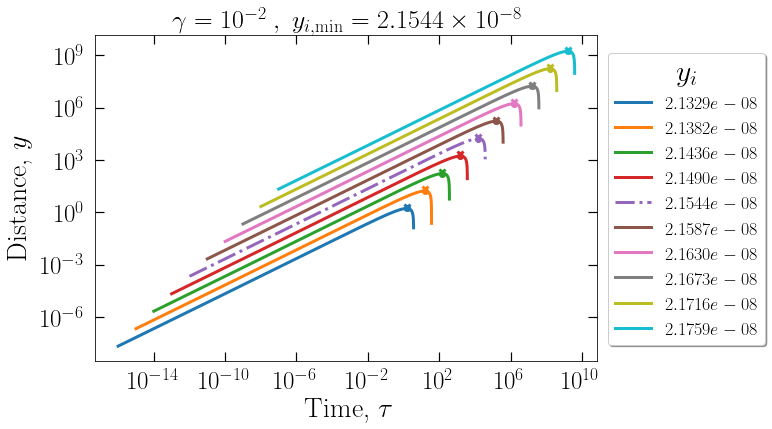

In [10]:
gamma = 1e-2
y_i_ref = 2.1544e-08
tau_i, tau_f = 1e-16, 1e15
gamma_values = np.geomspace(1e-10, 1, 5)

 
#yi_arr = np.array([0.9*y_i_ref, 0.95*y_i_ref, 0.99*y_i_ref,  
                   #y_i_ref, 1.01*y_i_ref, 1.05*y_i_ref, 1.1*y_i_ref])

    
yi_1 = 0.99*y_i_ref
yi_2 = 1.01*y_i_ref

yi_arr1 = np.geomspace(yi_1, y_i_ref, 5)

yi_arr2 = np.geomspace(y_i_ref, yi_2, 6)

sliced_yi_arr2 = yi_arr2[1:6]
#print(sliced_yi_arr2)
yi_arr = np.append(yi_arr1, sliced_yi_arr2)

fig, ax = plt.subplots(1, figsize = (9, 6))
plt.rc('lines', linewidth = 3)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')






colors = [ 'C0','C1','C2','C3','C4','C5', 'C6', 'C7', 'C8', 'C9']
marker_handles = []
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])

    
    if i == 4:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$', ls ='-.')
    else:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$')

    
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        yta_analytic = r_turnaround_full(tauta_numerical, gamma)
        print( "y_i =", '%0.4e'%y_i , ",",  "tau_ta_numerical =", '%0.4e'%tauta_numerical, ",", "yta_numerical =", '%0.4e'%yta_numerical, ",", "yta_analytic =", '%0.4e'%yta_analytic)
            
        yta_numerical_marker = ax.scatter(tauta_numerical* (10**i), yta_numerical* (10**i),color=color, zorder=1  )
        yta_analytic_marker = ax.scatter(tauta_numerical* (10**i), yta_analytic* (10**i), color=color,  marker='x',  zorder=9)
        if i == 0:
            marker_handles.append((yta_numerical_marker, "Numerical "))
            marker_handles.append((yta_analytic_marker, "Analytic"))

if len(marker_handles) == 2:  
    legend1 = plt.legend(
        handles=[marker_handles[0][0], marker_handles[1][0]],
        labels=[marker_handles[0][1], marker_handles[1][1]],prop={'size':16.2},
        loc=(1.02, 0.58), title=r'$y_\mathrm{ta}$', title_fontsize= 29, fontsize=12)
    #ax.add_artist(legend1)


lines = ax.get_lines()
legend2 = plt.legend( prop={'size':18}, 
                     loc=(1.02, 0.05), shadow=True, title='$y_{i}$', title_fontsize= 30,
    facecolor='white', fontsize=12)


ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


#plt.text(tau_i, 1e-4, r'$\gamma = 3.6\times 10^{-5}$', fontsize = 25)
#plt.text(tau_i, 1e-6, r'$\tau_i = 10^{-28}$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28, labelpad=9)
plt.title(r'$\gamma = 10^{-2}\; , \; y_{i, \mathrm{min}} = 2.1544 \times 10^{-8}$', fontsize= 26)
plt.savefig('yta_min5.pdf', bbox_inches='tight')

plt.show()

y_i = 2.1329e-08 , tau_ta_numerical = 9.6233e+03 , yta_numerical = 5.7758e+02 , yta_analytic = 7.1810e+02
y_i = 2.1382e-08 , tau_ta_numerical = 9.4717e+03 , yta_numerical = 5.7150e+02 , yta_analytic = 7.1054e+02
y_i = 2.1436e-08 , tau_ta_numerical = 9.3226e+03 , yta_numerical = 5.6549e+02 , yta_analytic = 7.0306e+02
y_i = 2.1490e-08 , tau_ta_numerical = 9.1760e+03 , yta_numerical = 5.5954e+02 , yta_analytic = 6.9567e+02
y_i = 2.1544e-08 , tau_ta_numerical = 9.0318e+03 , yta_numerical = 5.5367e+02 , yta_analytic = 6.8836e+02
y_i = 2.1587e-08 , tau_ta_numerical = 8.9194e+03 , yta_numerical = 5.4906e+02 , yta_analytic = 6.8264e+02
y_i = 2.1630e-08 , tau_ta_numerical = 8.8084e+03 , yta_numerical = 5.4450e+02 , yta_analytic = 6.7696e+02
y_i = 2.1673e-08 , tau_ta_numerical = 8.6989e+03 , yta_numerical = 5.3998e+02 , yta_analytic = 6.7134e+02
y_i = 2.1716e-08 , tau_ta_numerical = 8.5908e+03 , yta_numerical = 5.3550e+02 , yta_analytic = 6.6577e+02
y_i = 2.1759e-08 , tau_ta_numerical = 8.4842e+

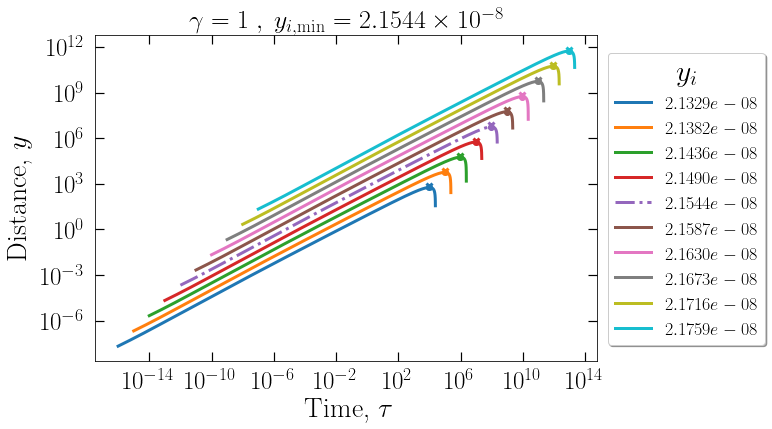

In [11]:
gamma = 1
y_i_ref = 2.1544e-08
tau_i, tau_f = 1e-16, 1e15
gamma_values = np.geomspace(1e-10, 1, 5)

 
#yi_arr = np.array([0.9*y_i_ref, 0.95*y_i_ref, 0.99*y_i_ref,  
                   #y_i_ref, 1.01*y_i_ref, 1.05*y_i_ref, 1.1*y_i_ref])

    
yi_1 = 0.99*y_i_ref
yi_2 = 1.01*y_i_ref

yi_arr1 = np.geomspace(yi_1, y_i_ref, 5)

yi_arr2 = np.geomspace(y_i_ref, yi_2, 6)

sliced_yi_arr2 = yi_arr2[1:6]
#print(sliced_yi_arr2)
yi_arr = np.append(yi_arr1, sliced_yi_arr2)

fig, ax = plt.subplots(1, figsize = (9, 6))
plt.rc('lines', linewidth = 3)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')





colors = [ 'C0','C1','C2','C3','C4','C5', 'C6', 'C7', 'C8', 'C9']
marker_handles = []
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])

    
    if i == 4:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$', ls ='-.')
    else:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$')

    
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        yta_analytic = r_turnaround_full(tauta_numerical, gamma)
        print( "y_i =", '%0.4e'%y_i , ",",  "tau_ta_numerical =", '%0.4e'%tauta_numerical, ",", "yta_numerical =", '%0.4e'%yta_numerical, ",", "yta_analytic =", '%0.4e'%yta_analytic)
            
        yta_numerical_marker = ax.scatter(tauta_numerical* (10**i), yta_numerical* (10**i),color=color, zorder=1  )
        yta_analytic_marker = ax.scatter(tauta_numerical* (10**i), yta_analytic* (10**i), color=color,  marker='x',  zorder=9)
        if i == 0:
            marker_handles.append((yta_numerical_marker, "Numerical "))
            marker_handles.append((yta_analytic_marker, "Analytic"))

if len(marker_handles) == 2:  
    legend1 = plt.legend(
        handles=[marker_handles[0][0], marker_handles[1][0]],
        labels=[marker_handles[0][1], marker_handles[1][1]],prop={'size':16.2},
        loc=(1.02, 0.58), title=r'$y_\mathrm{ta}$', title_fontsize= 29, fontsize=12)
    #ax.add_artist(legend1)


lines = ax.get_lines()
legend2 = plt.legend( prop={'size':18}, 
                     loc=(1.02, 0.05), shadow=True, title='$y_{i}$', title_fontsize= 30,
    facecolor='white', fontsize=12)


ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


#plt.text(tau_i, 1e-4, r'$\gamma = 3.6\times 10^{-5}$', fontsize = 25)
#plt.text(tau_i, 1e-6, r'$\tau_i = 10^{-28}$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28, labelpad=9)
plt.title(r'$\gamma = 1\; , \; y_{i, \mathrm{min}} = 2.1544 \times 10^{-8}$', fontsize= 26)
plt.savefig('yta_min6.pdf', bbox_inches='tight')

plt.show()

In [ ]:
# y vs tau plots with spacings y_i = [0.95 y_i_min_ref - 1.05 yi_min_ref]

y_i = 7.3555e-11 , tau_ta_numerical = 5.1791e-15 , yta_numerical = 3.5175e-10 , yta_analytic = 4.5718e-10
y_i = 7.4504e-11 , tau_ta_numerical = 5.2056e-15 , yta_numerical = 3.6302e-10 , yta_analytic = 4.5881e-10
y_i = 7.5466e-11 , tau_ta_numerical = 5.6665e-15 , yta_numerical = 3.7514e-10 , yta_analytic = 4.8663e-10
y_i = 7.6439e-11 , tau_ta_numerical = 5.9296e-15 , yta_numerical = 3.8759e-10 , yta_analytic = 5.0217e-10
y_i = 7.7426e-11 , tau_ta_numerical = 6.2099e-15 , yta_numerical = 4.0056e-10 , yta_analytic = 5.1848e-10
y_i = 7.8185e-11 , tau_ta_numerical = 6.4264e-15 , yta_numerical = 4.1081e-10 , yta_analytic = 5.3090e-10
y_i = 7.8952e-11 , tau_ta_numerical = 6.6567e-15 , yta_numerical = 4.2138e-10 , yta_analytic = 5.4396e-10
y_i = 7.9726e-11 , tau_ta_numerical = 6.8961e-15 , yta_numerical = 4.3231e-10 , yta_analytic = 5.5738e-10
y_i = 8.0508e-11 , tau_ta_numerical = 7.1479e-15 , yta_numerical = 4.4402e-10 , yta_analytic = 5.7132e-10
y_i = 8.1297e-11 , tau_ta_numerical = 7.4145e-

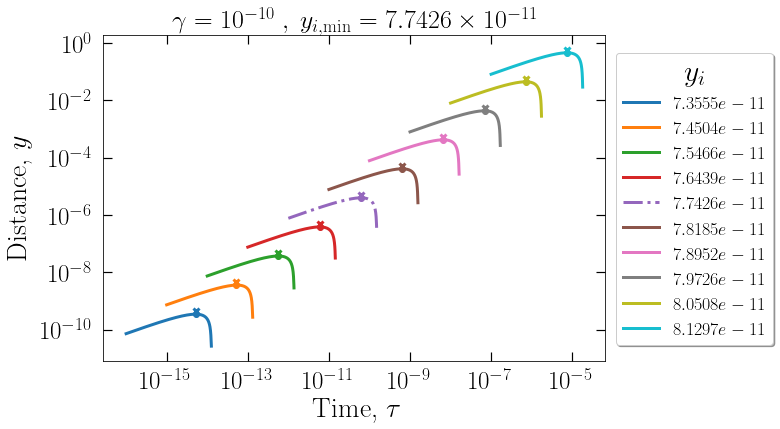

In [46]:
gamma = 1e-10
y_i_ref =7.7426e-11
tau_i, tau_f = 1e-16, 1e15
gamma_values = np.geomspace(1e-10, 1, 5)

 
#yi_arr = np.array([0.9*y_i_ref, 0.95*y_i_ref, 0.99*y_i_ref,  
                   #y_i_ref, 1.01*y_i_ref, 1.05*y_i_ref, 1.1*y_i_ref])

    
yi_1 = 0.95*y_i_ref
yi_2 = 1.05*y_i_ref

yi_arr1 = np.geomspace(yi_1, y_i_ref, 5)

yi_arr2 = np.geomspace(y_i_ref, yi_2, 6)

sliced_yi_arr2 = yi_arr2[1:6]
#print(sliced_yi_arr2)
yi_arr = np.append(yi_arr1, sliced_yi_arr2)

fig, ax = plt.subplots(1, figsize = (9, 6))
plt.rc('lines', linewidth = 3)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')




colors = [ 'C0','C1','C2','C3','C4','C5', 'C6', 'C7', 'C8', 'C9']
marker_handles = []
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])

    
    if i == 4:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$', ls ='-.')
    else:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$')

    
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        yta_analytic = r_turnaround_full(tauta_numerical, gamma)
        print( "y_i =", '%0.4e'%y_i , ",",  "tau_ta_numerical =", '%0.4e'%tauta_numerical, ",", "yta_numerical =", '%0.4e'%yta_numerical, ",", "yta_analytic =", '%0.4e'%yta_analytic)
            
        yta_numerical_marker = ax.scatter(tauta_numerical* (10**i), yta_numerical* (10**i),color=color, zorder=1  )
        yta_analytic_marker = ax.scatter(tauta_numerical* (10**i), yta_analytic* (10**i), color=color,  marker='x',  zorder=9)
        if i == 0:
            marker_handles.append((yta_numerical_marker, "Numerical "))
            marker_handles.append((yta_analytic_marker, "Analytic"))

if len(marker_handles) == 2:  
    legend1 = plt.legend(
        handles=[marker_handles[0][0], marker_handles[1][0]],
        labels=[marker_handles[0][1], marker_handles[1][1]],prop={'size':16.2},
        loc=(1.02, 0.58), title=r'$y_\mathrm{ta}$', title_fontsize= 29, fontsize=12)
    #ax.add_artist(legend1)


lines = ax.get_lines()
legend2 = plt.legend( prop={'size':18}, 
                     loc=(1.02, 0.05), shadow=True, title='$y_{i}$', title_fontsize= 30,
    facecolor='white', fontsize=12)


ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


#plt.text(tau_i, 1e-4, r'$\gamma = 3.6\times 10^{-5}$', fontsize = 25)
#plt.text(tau_i, 1e-6, r'$\tau_i = 10^{-28}$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28, labelpad=9)
plt.title(r'$\gamma = 10^{-10}\; , \; y_{i, \mathrm{min}} =  7.7426 \times 10^{-11}$', fontsize= 26)
plt.savefig('yta_min7.pdf', bbox_inches='tight')

plt.show()

y_i = 1.2269e-09 , tau_ta_numerical = 2.5215e-08 , yta_numerical = 1.1138e-05 , yta_analytic = 1.3648e-05
y_i = 1.2428e-09 , tau_ta_numerical = 2.7206e-08 , yta_numerical = 1.1717e-05 , yta_analytic = 1.4357e-05
y_i = 1.2588e-09 , tau_ta_numerical = 2.9354e-08 , yta_numerical = 1.2326e-05 , yta_analytic = 1.5104e-05
y_i = 1.2750e-09 , tau_ta_numerical = 3.1673e-08 , yta_numerical = 1.2967e-05 , yta_analytic = 1.5889e-05
y_i = 1.2915e-09 , tau_ta_numerical = 3.4176e-08 , yta_numerical = 1.3642e-05 , yta_analytic = 1.6716e-05
y_i = 1.3042e-09 , tau_ta_numerical = 3.6214e-08 , yta_numerical = 1.4179e-05 , yta_analytic = 1.7374e-05
y_i = 1.3170e-09 , tau_ta_numerical = 3.8374e-08 , yta_numerical = 1.4738e-05 , yta_analytic = 1.8058e-05
y_i = 1.3299e-09 , tau_ta_numerical = 4.0664e-08 , yta_numerical = 1.5319e-05 , yta_analytic = 1.8769e-05
y_i = 1.3429e-09 , tau_ta_numerical = 4.3090e-08 , yta_numerical = 1.5922e-05 , yta_analytic = 1.9509e-05
y_i = 1.3561e-09 , tau_ta_numerical = 4.5663e-

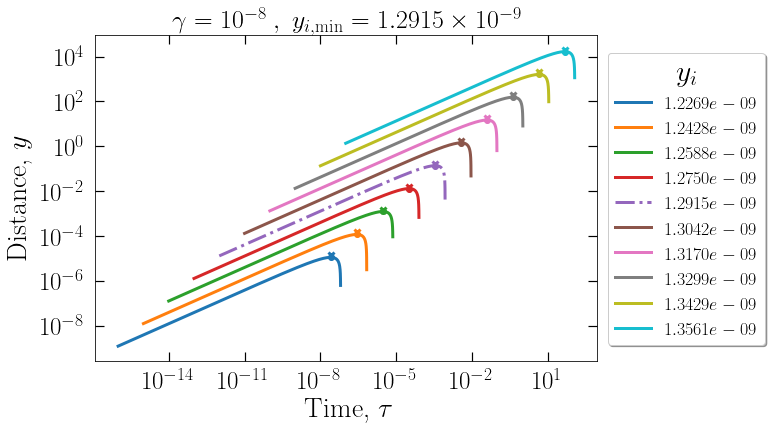

In [13]:
gamma = 1e-8
y_i_ref = 1.2915e-09
tau_i, tau_f = 1e-16, 1e15
gamma_values = np.geomspace(1e-10, 1, 5)

 
#yi_arr = np.array([0.9*y_i_ref, 0.95*y_i_ref, 0.99*y_i_ref,  
                   #y_i_ref, 1.01*y_i_ref, 1.05*y_i_ref, 1.1*y_i_ref])

    
yi_1 = 0.95*y_i_ref
yi_2 = 1.05*y_i_ref

yi_arr1 = np.geomspace(yi_1, y_i_ref, 5)

yi_arr2 = np.geomspace(y_i_ref, yi_2, 6)

sliced_yi_arr2 = yi_arr2[1:6]
#print(sliced_yi_arr2)
yi_arr = np.append(yi_arr1, sliced_yi_arr2)

fig, ax = plt.subplots(1, figsize = (9, 6))
plt.rc('lines', linewidth = 3)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')




colors = [ 'C0','C1','C2','C3','C4','C5', 'C6', 'C7', 'C8', 'C9']
marker_handles = []
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])

    
    if i == 4:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$', ls ='-.')
    else:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$')

    
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        yta_analytic = r_turnaround_full(tauta_numerical, gamma)
        print( "y_i =", '%0.4e'%y_i , ",",  "tau_ta_numerical =", '%0.4e'%tauta_numerical, ",", "yta_numerical =", '%0.4e'%yta_numerical, ",", "yta_analytic =", '%0.4e'%yta_analytic)
            
        yta_numerical_marker = ax.scatter(tauta_numerical* (10**i), yta_numerical* (10**i),color=color, zorder=1  )
        yta_analytic_marker = ax.scatter(tauta_numerical* (10**i), yta_analytic* (10**i), color=color,  marker='x',  zorder=9)
        if i == 0:
            marker_handles.append((yta_numerical_marker, "Numerical "))
            marker_handles.append((yta_analytic_marker, "Analytic"))

if len(marker_handles) == 2:  
    legend1 = plt.legend(
        handles=[marker_handles[0][0], marker_handles[1][0]],
        labels=[marker_handles[0][1], marker_handles[1][1]],prop={'size':16.2},
        loc=(1.02, 0.58), title=r'$y_\mathrm{ta}$', title_fontsize= 29, fontsize=12)
    #ax.add_artist(legend1)


lines = ax.get_lines()
legend2 = plt.legend( prop={'size':18}, 
                     loc=(1.02, 0.05), shadow=True, title='$y_{i}$', title_fontsize= 30,
    facecolor='white', fontsize=12)


ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


#plt.text(tau_i, 1e-4, r'$\gamma = 3.6\times 10^{-5}$', fontsize = 25)
#plt.text(tau_i, 1e-6, r'$\tau_i = 10^{-28}$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28, labelpad=9)
plt.title(r'$\gamma = 10^{-8}\; , \; y_{i, \mathrm{min}} =  1.2915 \times 10^{-9}$', fontsize= 26)
plt.savefig('yta_min8.pdf', bbox_inches='tight')

plt.show()

y_i = 1.2269e-09 , tau_ta_numerical = 1.4904e-07 , yta_numerical = 3.5660e-05 , yta_analytic = 4.4455e-05
y_i = 1.2428e-09 , tau_ta_numerical = 1.5082e-07 , yta_numerical = 3.5961e-05 , yta_analytic = 4.4810e-05
y_i = 1.2588e-09 , tau_ta_numerical = 1.5293e-07 , yta_numerical = 3.6312e-05 , yta_analytic = 4.5227e-05
y_i = 1.2750e-09 , tau_ta_numerical = 1.5536e-07 , yta_numerical = 3.6713e-05 , yta_analytic = 4.5707e-05
y_i = 1.2915e-09 , tau_ta_numerical = 1.5813e-07 , yta_numerical = 3.7166e-05 , yta_analytic = 4.6250e-05
y_i = 1.3042e-09 , tau_ta_numerical = 1.6047e-07 , yta_numerical = 3.7546e-05 , yta_analytic = 4.6707e-05
y_i = 1.3170e-09 , tau_ta_numerical = 1.6301e-07 , yta_numerical = 3.7956e-05 , yta_analytic = 4.7202e-05
y_i = 1.3299e-09 , tau_ta_numerical = 1.6577e-07 , yta_numerical = 3.8397e-05 , yta_analytic = 4.7735e-05
y_i = 1.3429e-09 , tau_ta_numerical = 1.6875e-07 , yta_numerical = 3.8871e-05 , yta_analytic = 4.8308e-05
y_i = 1.3561e-09 , tau_ta_numerical = 1.7196e-

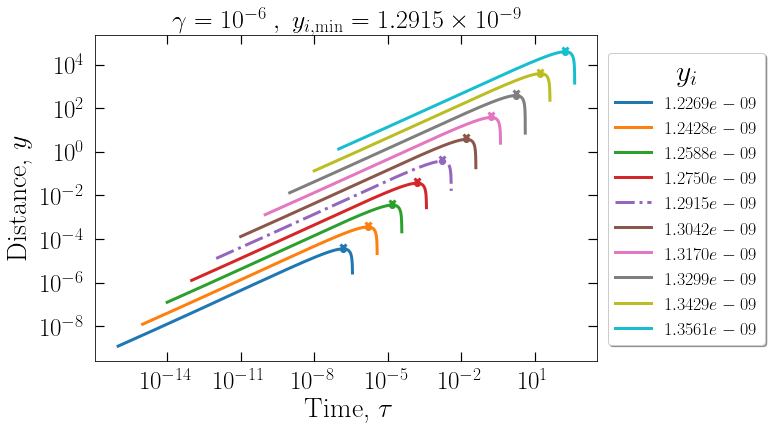

In [14]:
gamma = 1e-6
y_i_ref = 1.2915e-09
tau_i, tau_f = 1e-16, 1e15
gamma_values = np.geomspace(1e-10, 1, 5)

 
#yi_arr = np.array([0.9*y_i_ref, 0.95*y_i_ref, 0.99*y_i_ref,  
                   #y_i_ref, 1.01*y_i_ref, 1.05*y_i_ref, 1.1*y_i_ref])

    
yi_1 = 0.95*y_i_ref
yi_2 = 1.05*y_i_ref

yi_arr1 = np.geomspace(yi_1, y_i_ref, 5)

yi_arr2 = np.geomspace(y_i_ref, yi_2, 6)

sliced_yi_arr2 = yi_arr2[1:6]
#print(sliced_yi_arr2)
yi_arr = np.append(yi_arr1, sliced_yi_arr2)

fig, ax = plt.subplots(1, figsize = (9, 6))
plt.rc('lines', linewidth = 3)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')



colors = [ 'C0','C1','C2','C3','C4','C5', 'C6', 'C7', 'C8', 'C9']
marker_handles = []
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])

    
    if i == 4:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$', ls ='-.')
    else:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$')

    
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        yta_analytic = r_turnaround_full(tauta_numerical, gamma)
        print( "y_i =", '%0.4e'%y_i , ",",  "tau_ta_numerical =", '%0.4e'%tauta_numerical, ",", "yta_numerical =", '%0.4e'%yta_numerical, ",", "yta_analytic =", '%0.4e'%yta_analytic)
            
        yta_numerical_marker = ax.scatter(tauta_numerical* (10**i), yta_numerical* (10**i),color=color, zorder=1  )
        yta_analytic_marker = ax.scatter(tauta_numerical* (10**i), yta_analytic* (10**i), color=color,  marker='x',  zorder=9)
        if i == 0:
            marker_handles.append((yta_numerical_marker, "Numerical "))
            marker_handles.append((yta_analytic_marker, "Analytic"))

if len(marker_handles) == 2:  
    legend1 = plt.legend(
        handles=[marker_handles[0][0], marker_handles[1][0]],
        labels=[marker_handles[0][1], marker_handles[1][1]],prop={'size':16.2},
        loc=(1.02, 0.58), title=r'$y_\mathrm{ta}$', title_fontsize= 29, fontsize=12)
    #ax.add_artist(legend1)


lines = ax.get_lines()
legend2 = plt.legend( prop={'size':18}, 
                     loc=(1.02, 0.05), shadow=True, title='$y_{i}$', title_fontsize= 30,
    facecolor='white', fontsize=12)


ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


#plt.text(tau_i, 1e-4, r'$\gamma = 3.6\times 10^{-5}$', fontsize = 25)
#plt.text(tau_i, 1e-6, r'$\tau_i = 10^{-28}$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28, labelpad=9)
plt.title(r'$\gamma = 10^{-6}\; , \; y_{i, \mathrm{min}} =  1.2915 \times 10^{-9}$', fontsize= 26)
plt.savefig('yta_min9.pdf', bbox_inches='tight')

plt.show()

y_i = 1.2269e-09 , tau_ta_numerical = 3.7963e-01 , yta_numerical = 6.6628e-01 , yta_analytic = 8.3225e-01
y_i = 1.2428e-09 , tau_ta_numerical = 3.4513e-01 , yta_numerical = 6.2524e-01 , yta_analytic = 7.8102e-01
y_i = 1.2588e-09 , tau_ta_numerical = 3.1519e-01 , yta_numerical = 5.8852e-01 , yta_analytic = 7.3517e-01
y_i = 1.2750e-09 , tau_ta_numerical = 2.7499e-01 , yta_numerical = 5.3729e-01 , yta_analytic = 6.7125e-01
y_i = 1.2915e-09 , tau_ta_numerical = 2.5592e-01 , yta_numerical = 5.1215e-01 , yta_analytic = 6.3985e-01
y_i = 1.3042e-09 , tau_ta_numerical = 2.3976e-01 , yta_numerical = 4.9035e-01 , yta_analytic = 6.1263e-01
y_i = 1.3170e-09 , tau_ta_numerical = 2.2409e-01 , yta_numerical = 4.6872e-01 , yta_analytic = 5.8563e-01
y_i = 1.3299e-09 , tau_ta_numerical = 2.0918e-01 , yta_numerical = 4.4768e-01 , yta_analytic = 5.5936e-01
y_i = 1.3429e-09 , tau_ta_numerical = 1.9504e-01 , yta_numerical = 4.2726e-01 , yta_analytic = 5.3386e-01
y_i = 1.3561e-09 , tau_ta_numerical = 1.8184e-

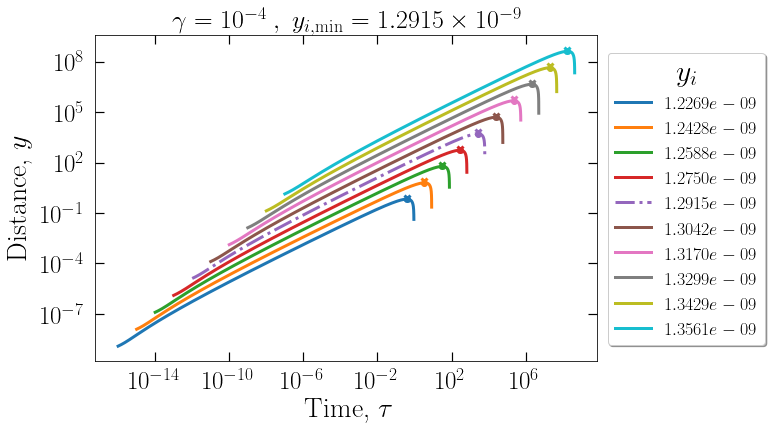

In [15]:
gamma = 1e-4
y_i_ref = 1.2915e-09
tau_i, tau_f = 1e-16, 1e15
gamma_values = np.geomspace(1e-10, 1, 5)

 
#yi_arr = np.array([0.9*y_i_ref, 0.95*y_i_ref, 0.99*y_i_ref,  
                   #y_i_ref, 1.01*y_i_ref, 1.05*y_i_ref, 1.1*y_i_ref])

    
yi_1 = 0.95*y_i_ref
yi_2 = 1.05*y_i_ref

yi_arr1 = np.geomspace(yi_1, y_i_ref, 5)

yi_arr2 = np.geomspace(y_i_ref, yi_2, 6)

sliced_yi_arr2 = yi_arr2[1:6]
#print(sliced_yi_arr2)
yi_arr = np.append(yi_arr1, sliced_yi_arr2)

fig, ax = plt.subplots(1, figsize = (9, 6))
plt.rc('lines', linewidth = 3)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')



colors = [ 'C0','C1','C2','C3','C4','C5', 'C6', 'C7', 'C8', 'C9']
marker_handles = []
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])

    
    if i == 4:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$', ls ='-.')
    else:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$')

    
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        yta_analytic = r_turnaround_full(tauta_numerical, gamma)
        print( "y_i =", '%0.4e'%y_i , ",",  "tau_ta_numerical =", '%0.4e'%tauta_numerical, ",", "yta_numerical =", '%0.4e'%yta_numerical, ",", "yta_analytic =", '%0.4e'%yta_analytic)
            
        yta_numerical_marker = ax.scatter(tauta_numerical* (10**i), yta_numerical* (10**i),color=color, zorder=1  )
        yta_analytic_marker = ax.scatter(tauta_numerical* (10**i), yta_analytic* (10**i), color=color,  marker='x',  zorder=9)
        if i == 0:
            marker_handles.append((yta_numerical_marker, "Numerical "))
            marker_handles.append((yta_analytic_marker, "Analytic"))

if len(marker_handles) == 2:  
    legend1 = plt.legend(
        handles=[marker_handles[0][0], marker_handles[1][0]],
        labels=[marker_handles[0][1], marker_handles[1][1]],prop={'size':16.2},
        loc=(1.02, 0.58), title=r'$y_\mathrm{ta}$', title_fontsize= 29, fontsize=12)
    #ax.add_artist(legend1)


lines = ax.get_lines()
legend2 = plt.legend( prop={'size':18}, 
                     loc=(1.02, 0.05), shadow=True, title='$y_{i}$', title_fontsize= 30,
    facecolor='white', fontsize=12)


ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


#plt.text(tau_i, 1e-4, r'$\gamma = 3.6\times 10^{-5}$', fontsize = 25)
#plt.text(tau_i, 1e-6, r'$\tau_i = 10^{-28}$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28, labelpad=9)
plt.title(r'$\gamma = 10^{-4}\; , \; y_{i, \mathrm{min}} =  1.2915 \times 10^{-9}$', fontsize= 26)
plt.savefig('yta_min10.pdf', bbox_inches='tight')

plt.show()

y_i = 2.0467e-08 , tau_ta_numerical = 1.3078e+00 , yta_numerical = 1.5398e+00 , yta_analytic = 1.8967e+00
y_i = 2.0731e-08 , tau_ta_numerical = 1.3601e+00 , yta_numerical = 1.5809e+00 , yta_analytic = 1.9470e+00
y_i = 2.0998e-08 , tau_ta_numerical = 1.4165e+00 , yta_numerical = 1.6247e+00 , yta_analytic = 2.0005e+00
y_i = 2.1269e-08 , tau_ta_numerical = 1.4772e+00 , yta_numerical = 1.6711e+00 , yta_analytic = 2.0573e+00
y_i = 2.1544e-08 , tau_ta_numerical = 1.5426e+00 , yta_numerical = 1.7204e+00 , yta_analytic = 2.1176e+00
y_i = 2.1755e-08 , tau_ta_numerical = 1.5956e+00 , yta_numerical = 1.7599e+00 , yta_analytic = 2.1659e+00
y_i = 2.1969e-08 , tau_ta_numerical = 1.6517e+00 , yta_numerical = 1.8012e+00 , yta_analytic = 2.2164e+00
y_i = 2.2184e-08 , tau_ta_numerical = 1.7109e+00 , yta_numerical = 1.8442e+00 , yta_analytic = 2.2691e+00
y_i = 2.2402e-08 , tau_ta_numerical = 1.7734e+00 , yta_numerical = 1.8892e+00 , yta_analytic = 2.3241e+00
y_i = 2.2621e-08 , tau_ta_numerical = 1.8395e+

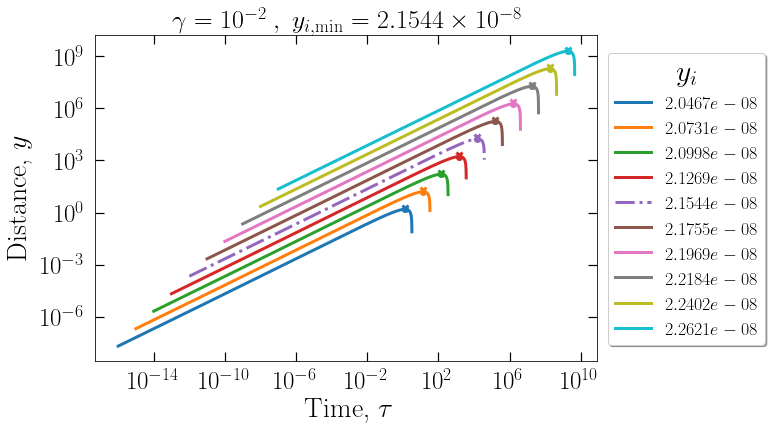

In [16]:
gamma = 1e-2
y_i_ref = 2.1544e-08
tau_i, tau_f = 1e-16, 1e15
gamma_values = np.geomspace(1e-10, 1, 5)

 
#yi_arr = np.array([0.9*y_i_ref, 0.95*y_i_ref, 0.99*y_i_ref,  
                   #y_i_ref, 1.01*y_i_ref, 1.05*y_i_ref, 1.1*y_i_ref])

    
yi_1 = 0.95*y_i_ref
yi_2 = 1.05*y_i_ref

yi_arr1 = np.geomspace(yi_1, y_i_ref, 5)

yi_arr2 = np.geomspace(y_i_ref, yi_2, 6)

sliced_yi_arr2 = yi_arr2[1:6]
#print(sliced_yi_arr2)
yi_arr = np.append(yi_arr1, sliced_yi_arr2)

fig, ax = plt.subplots(1, figsize = (9, 6))
plt.rc('lines', linewidth = 3)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')



colors = [ 'C0','C1','C2','C3','C4','C5', 'C6', 'C7', 'C8', 'C9']
marker_handles = []
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])

    
    if i == 4:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$', ls ='-.')
    else:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$')

    
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        yta_analytic = r_turnaround_full(tauta_numerical, gamma)
        print( "y_i =", '%0.4e'%y_i , ",",  "tau_ta_numerical =", '%0.4e'%tauta_numerical, ",", "yta_numerical =", '%0.4e'%yta_numerical, ",", "yta_analytic =", '%0.4e'%yta_analytic)
            
        yta_numerical_marker = ax.scatter(tauta_numerical* (10**i), yta_numerical* (10**i),color=color, zorder=1  )
        yta_analytic_marker = ax.scatter(tauta_numerical* (10**i), yta_analytic* (10**i), color=color,  marker='x',  zorder=9)
        if i == 0:
            marker_handles.append((yta_numerical_marker, "Numerical "))
            marker_handles.append((yta_analytic_marker, "Analytic"))

if len(marker_handles) == 2:  
    legend1 = plt.legend(
        handles=[marker_handles[0][0], marker_handles[1][0]],
        labels=[marker_handles[0][1], marker_handles[1][1]],prop={'size':16.2},
        loc=(1.02, 0.58), title=r'$y_\mathrm{ta}$', title_fontsize= 29, fontsize=12)
    #ax.add_artist(legend1)


lines = ax.get_lines()
legend2 = plt.legend( prop={'size':18}, 
                     loc=(1.02, 0.05), shadow=True, title='$y_{i}$', title_fontsize= 30,
    facecolor='white', fontsize=12)


ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


#plt.text(tau_i, 1e-4, r'$\gamma = 3.6\times 10^{-5}$', fontsize = 25)
#plt.text(tau_i, 1e-6, r'$\tau_i = 10^{-28}$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28, labelpad=9)
plt.title(r'$\gamma = 10^{-2}\; , \; y_{i, \mathrm{min}} = 2.1544 \times 10^{-8}$', fontsize= 26)
plt.savefig('yta_min11.pdf', bbox_inches='tight')

plt.show()

y_i = 2.0467e-08 , tau_ta_numerical = 1.2507e+04 , yta_numerical = 6.8788e+02 , yta_analytic = 8.5523e+02
y_i = 2.0731e-08 , tau_ta_numerical = 1.1528e+04 , yta_numerical = 6.5151e+02 , yta_analytic = 8.1001e+02
y_i = 2.0998e-08 , tau_ta_numerical = 1.0624e+04 , yta_numerical = 6.1695e+02 , yta_analytic = 7.6705e+02
y_i = 2.1269e-08 , tau_ta_numerical = 9.7936e+03 , yta_numerical = 5.8438e+02 , yta_analytic = 7.2655e+02
y_i = 2.1544e-08 , tau_ta_numerical = 9.0318e+03 , yta_numerical = 5.5367e+02 , yta_analytic = 6.8836e+02
y_i = 2.1755e-08 , tau_ta_numerical = 8.4945e+03 , yta_numerical = 5.3148e+02 , yta_analytic = 6.6078e+02
y_i = 2.1969e-08 , tau_ta_numerical = 7.9910e+03 , yta_numerical = 5.1027e+02 , yta_analytic = 6.3440e+02
y_i = 2.2184e-08 , tau_ta_numerical = 7.5194e+03 , yta_numerical = 4.8999e+02 , yta_analytic = 6.0919e+02
y_i = 2.2402e-08 , tau_ta_numerical = 7.0776e+03 , yta_numerical = 4.7061e+02 , yta_analytic = 5.8508e+02
y_i = 2.2621e-08 , tau_ta_numerical = 6.6636e+

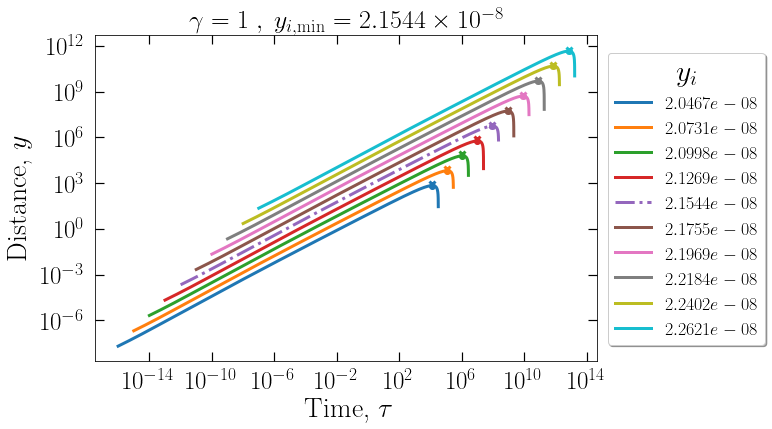

In [17]:
gamma = 1
y_i_ref = 2.1544e-08
tau_i, tau_f = 1e-16, 1e15
gamma_values = np.geomspace(1e-10, 1, 5)

 
#yi_arr = np.array([0.9*y_i_ref, 0.95*y_i_ref, 0.99*y_i_ref,  
                   #y_i_ref, 1.01*y_i_ref, 1.05*y_i_ref, 1.1*y_i_ref])

    
yi_1 = 0.95*y_i_ref
yi_2 = 1.05*y_i_ref

yi_arr1 = np.geomspace(yi_1, y_i_ref, 5)

yi_arr2 = np.geomspace(y_i_ref, yi_2, 6)

sliced_yi_arr2 = yi_arr2[1:6]
#print(sliced_yi_arr2)
yi_arr = np.append(yi_arr1, sliced_yi_arr2)

fig, ax = plt.subplots(1, figsize = (9, 6))
plt.rc('lines', linewidth = 3)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')






colors = [ 'C0','C1','C2','C3','C4','C5', 'C6', 'C7', 'C8', 'C9']
marker_handles = []
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])

    
    if i == 4:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$', ls ='-.')
    else:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$')

    
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        yta_analytic = r_turnaround_full(tauta_numerical, gamma)
        print( "y_i =", '%0.4e'%y_i , ",",  "tau_ta_numerical =", '%0.4e'%tauta_numerical, ",", "yta_numerical =", '%0.4e'%yta_numerical, ",", "yta_analytic =", '%0.4e'%yta_analytic)
            
        yta_numerical_marker = ax.scatter(tauta_numerical* (10**i), yta_numerical* (10**i),color=color, zorder=1  )
        yta_analytic_marker = ax.scatter(tauta_numerical* (10**i), yta_analytic* (10**i), color=color,  marker='x',  zorder=9)
        if i == 0:
            marker_handles.append((yta_numerical_marker, "Numerical "))
            marker_handles.append((yta_analytic_marker, "Analytic"))

if len(marker_handles) == 2:  
    legend1 = plt.legend(
        handles=[marker_handles[0][0], marker_handles[1][0]],
        labels=[marker_handles[0][1], marker_handles[1][1]],prop={'size':16.2},
        loc=(1.02, 0.58), title=r'$y_\mathrm{ta}$', title_fontsize= 29, fontsize=12)
    #ax.add_artist(legend1)


lines = ax.get_lines()
legend2 = plt.legend( prop={'size':18}, 
                     loc=(1.02, 0.05), shadow=True, title='$y_{i}$', title_fontsize= 30,
    facecolor='white', fontsize=12)


ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


#plt.text(tau_i, 1e-4, r'$\gamma = 3.6\times 10^{-5}$', fontsize = 25)
#plt.text(tau_i, 1e-6, r'$\tau_i = 10^{-28}$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28, labelpad=9)
plt.title(r'$\gamma = 1\; , \; y_{i, \mathrm{min}} = 2.1544 \times 10^{-8}$', fontsize= 26)
plt.savefig('yta_min12.pdf', bbox_inches='tight')

plt.show()

In [18]:
#y vs tau plots with y_i-spacings = [0.9 y_i_min_ref , yi_min_ref, 1.1 yi_min_ref]

y_i = 6.9683e-11 , tau_ta_numerical = 4.3851e-15 , yta_numerical = 3.0830e-10 , yta_analytic = 4.0710e-10
y_i = 7.1543e-11 , tau_ta_numerical = 4.6242e-15 , yta_numerical = 3.2850e-10 , yta_analytic = 4.2248e-10
y_i = 7.3453e-11 , tau_ta_numerical = 5.1745e-15 , yta_numerical = 3.5054e-10 , yta_analytic = 4.5690e-10
y_i = 7.5413e-11 , tau_ta_numerical = 5.6525e-15 , yta_numerical = 3.7448e-10 , yta_analytic = 4.8580e-10
y_i = 7.7426e-11 , tau_ta_numerical = 6.2099e-15 , yta_numerical = 4.0056e-10 , yta_analytic = 5.1848e-10
y_i = 7.8916e-11 , tau_ta_numerical = 6.6457e-15 , yta_numerical = 4.2088e-10 , yta_analytic = 5.4334e-10
y_i = 8.0435e-11 , tau_ta_numerical = 7.1225e-15 , yta_numerical = 4.4295e-10 , yta_analytic = 5.6992e-10
y_i = 8.1983e-11 , tau_ta_numerical = 7.6555e-15 , yta_numerical = 4.6605e-10 , yta_analytic = 5.9894e-10
y_i = 8.3560e-11 , tau_ta_numerical = 8.2288e-15 , yta_numerical = 4.9066e-10 , yta_analytic = 6.2940e-10
y_i = 8.5169e-11 , tau_ta_numerical = 8.8483e-

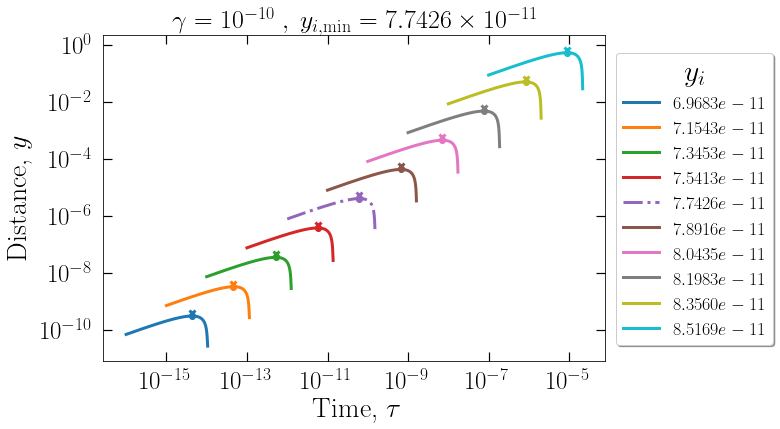

In [18]:
gamma = 1e-10
y_i_ref =7.7426e-11
tau_i, tau_f = 1e-16, 1e15
gamma_values = np.geomspace(1e-10, 1, 5)

 
#yi_arr = np.array([0.9*y_i_ref, 0.95*y_i_ref, 0.99*y_i_ref,  
                   #y_i_ref, 1.01*y_i_ref, 1.05*y_i_ref, 1.1*y_i_ref])

    
yi_1 = 0.9*y_i_ref
yi_2 = 1.1*y_i_ref

yi_arr1 = np.geomspace(yi_1, y_i_ref, 5)

yi_arr2 = np.geomspace(y_i_ref, yi_2, 6)

sliced_yi_arr2 = yi_arr2[1:6]
#print(sliced_yi_arr2)
yi_arr = np.append(yi_arr1, sliced_yi_arr2)

fig, ax = plt.subplots(1, figsize = (9, 6))
plt.rc('lines', linewidth = 3)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')



colors = [ 'C0','C1','C2','C3','C4','C5', 'C6', 'C7', 'C8', 'C9']
marker_handles = []
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])

    
    if i == 4:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$', ls ='-.')
    else:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$')

    
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        yta_analytic = r_turnaround_full(tauta_numerical, gamma)
        print( "y_i =", '%0.4e'%y_i , ",",  "tau_ta_numerical =", '%0.4e'%tauta_numerical, ",", "yta_numerical =", '%0.4e'%yta_numerical, ",", "yta_analytic =", '%0.4e'%yta_analytic)
            
        yta_numerical_marker = ax.scatter(tauta_numerical* (10**i), yta_numerical* (10**i),color=color, zorder=1  )
        yta_analytic_marker = ax.scatter(tauta_numerical* (10**i), yta_analytic* (10**i), color=color,  marker='x',  zorder=9)
        if i == 0:
            marker_handles.append((yta_numerical_marker, "Numerical "))
            marker_handles.append((yta_analytic_marker, "Analytic"))

if len(marker_handles) == 2:  
    legend1 = plt.legend(
        handles=[marker_handles[0][0], marker_handles[1][0]],
        labels=[marker_handles[0][1], marker_handles[1][1]],prop={'size':16.2},
        loc=(1.02, 0.58), title=r'$y_\mathrm{ta}$', title_fontsize= 29, fontsize=12)
    #ax.add_artist(legend1)


lines = ax.get_lines()
legend2 = plt.legend( prop={'size':18}, 
                     loc=(1.02, 0.05), shadow=True, title='$y_{i}$', title_fontsize= 30,
    facecolor='white', fontsize=12)


ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


#plt.text(tau_i, 1e-4, r'$\gamma = 3.6\times 10^{-5}$', fontsize = 25)
#plt.text(tau_i, 1e-6, r'$\tau_i = 10^{-28}$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28, labelpad=9)
plt.title(r'$\gamma = 10^{-10}\; , \; y_{i, \mathrm{min}} =  7.7426 \times 10^{-11}$', fontsize= 26)
plt.savefig('yta_min13.pdf', bbox_inches='tight')

plt.show()

y_i = 1.1624e-09 , tau_ta_numerical = 1.8313e-08 , yta_numerical = 8.9984e-06 , yta_analytic = 1.1027e-05
y_i = 1.1934e-09 , tau_ta_numerical = 2.1399e-08 , yta_numerical = 9.9832e-06 , yta_analytic = 1.2234e-05
y_i = 1.2252e-09 , tau_ta_numerical = 2.5009e-08 , yta_numerical = 1.1077e-05 , yta_analytic = 1.3574e-05
y_i = 1.2579e-09 , tau_ta_numerical = 2.9234e-08 , yta_numerical = 1.2292e-05 , yta_analytic = 1.5062e-05
y_i = 1.2915e-09 , tau_ta_numerical = 3.4176e-08 , yta_numerical = 1.3642e-05 , yta_analytic = 1.6716e-05
y_i = 1.3164e-09 , tau_ta_numerical = 3.8271e-08 , yta_numerical = 1.4711e-05 , yta_analytic = 1.8026e-05
y_i = 1.3417e-09 , tau_ta_numerical = 4.2858e-08 , yta_numerical = 1.5865e-05 , yta_analytic = 1.9439e-05
y_i = 1.3675e-09 , tau_ta_numerical = 4.7999e-08 , yta_numerical = 1.7110e-05 , yta_analytic = 2.0964e-05
y_i = 1.3938e-09 , tau_ta_numerical = 5.3760e-08 , yta_numerical = 1.8453e-05 , yta_analytic = 2.2610e-05
y_i = 1.4207e-09 , tau_ta_numerical = 6.0215e-

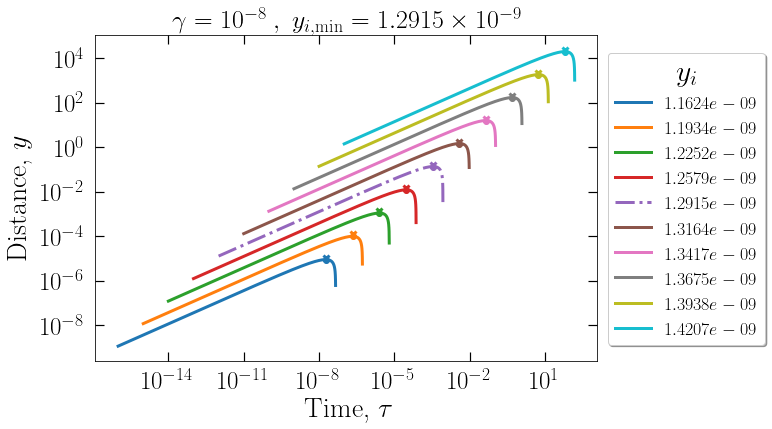

In [19]:
gamma = 1e-8
y_i_ref = 1.2915e-09
tau_i, tau_f = 1e-16, 1e15
gamma_values = np.geomspace(1e-10, 1, 5)

 
#yi_arr = np.array([0.9*y_i_ref, 0.95*y_i_ref, 0.99*y_i_ref,  
                   #y_i_ref, 1.01*y_i_ref, 1.05*y_i_ref, 1.1*y_i_ref])

    
yi_1 = 0.9*y_i_ref
yi_2 = 1.1*y_i_ref

yi_arr1 = np.geomspace(yi_1, y_i_ref, 5)

yi_arr2 = np.geomspace(y_i_ref, yi_2, 6)

sliced_yi_arr2 = yi_arr2[1:6]
#print(sliced_yi_arr2)
yi_arr = np.append(yi_arr1, sliced_yi_arr2)

fig, ax = plt.subplots(1, figsize = (9, 6))
plt.rc('lines', linewidth = 3)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')



colors = [ 'C0','C1','C2','C3','C4','C5', 'C6', 'C7', 'C8', 'C9']
marker_handles = []
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])

    
    if i == 4:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$', ls ='-.')
    else:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$')

    
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        yta_analytic = r_turnaround_full(tauta_numerical, gamma)
        print( "y_i =", '%0.4e'%y_i , ",",  "tau_ta_numerical =", '%0.4e'%tauta_numerical, ",", "yta_numerical =", '%0.4e'%yta_numerical, ",", "yta_analytic =", '%0.4e'%yta_analytic)
            
        yta_numerical_marker = ax.scatter(tauta_numerical* (10**i), yta_numerical* (10**i),color=color, zorder=1  )
        yta_analytic_marker = ax.scatter(tauta_numerical* (10**i), yta_analytic* (10**i), color=color,  marker='x',  zorder=9)
        if i == 0:
            marker_handles.append((yta_numerical_marker, "Numerical "))
            marker_handles.append((yta_analytic_marker, "Analytic"))

if len(marker_handles) == 2:  
    legend1 = plt.legend(
        handles=[marker_handles[0][0], marker_handles[1][0]],
        labels=[marker_handles[0][1], marker_handles[1][1]],prop={'size':16.2},
        loc=(1.02, 0.58), title=r'$y_\mathrm{ta}$', title_fontsize= 29, fontsize=12)
    #ax.add_artist(legend1)


lines = ax.get_lines()
legend2 = plt.legend( prop={'size':18}, 
                     loc=(1.02, 0.05), shadow=True, title='$y_{i}$', title_fontsize= 30,
    facecolor='white', fontsize=12)


ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


#plt.text(tau_i, 1e-4, r'$\gamma = 3.6\times 10^{-5}$', fontsize = 25)
#plt.text(tau_i, 1e-6, r'$\tau_i = 10^{-28}$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28, labelpad=9)
plt.title(r'$\gamma = 10^{-8}\; , \; y_{i, \mathrm{min}} =  1.2915 \times 10^{-9}$', fontsize= 26)
plt.savefig('yta_min14.pdf', bbox_inches='tight')

plt.show()

y_i = 1.1624e-09 , tau_ta_numerical = 1.4496e-07 , yta_numerical = 3.4939e-05 , yta_analytic = 4.3636e-05
y_i = 1.1934e-09 , tau_ta_numerical = 1.4626e-07 , yta_numerical = 3.5180e-05 , yta_analytic = 4.3898e-05
y_i = 1.2252e-09 , tau_ta_numerical = 1.4887e-07 , yta_numerical = 3.5631e-05 , yta_analytic = 4.4420e-05
y_i = 1.2579e-09 , tau_ta_numerical = 1.5280e-07 , yta_numerical = 3.6291e-05 , yta_analytic = 4.5203e-05
y_i = 1.2915e-09 , tau_ta_numerical = 1.5813e-07 , yta_numerical = 3.7166e-05 , yta_analytic = 4.6250e-05
y_i = 1.3164e-09 , tau_ta_numerical = 1.6289e-07 , yta_numerical = 3.7936e-05 , yta_analytic = 4.7178e-05
y_i = 1.3417e-09 , tau_ta_numerical = 1.6847e-07 , yta_numerical = 3.8825e-05 , yta_analytic = 4.8253e-05
y_i = 1.3675e-09 , tau_ta_numerical = 1.7491e-07 , yta_numerical = 3.9837e-05 , yta_analytic = 4.9479e-05
y_i = 1.3938e-09 , tau_ta_numerical = 1.8227e-07 , yta_numerical = 4.0977e-05 , yta_analytic = 5.0863e-05
y_i = 1.4207e-09 , tau_ta_numerical = 1.9063e-

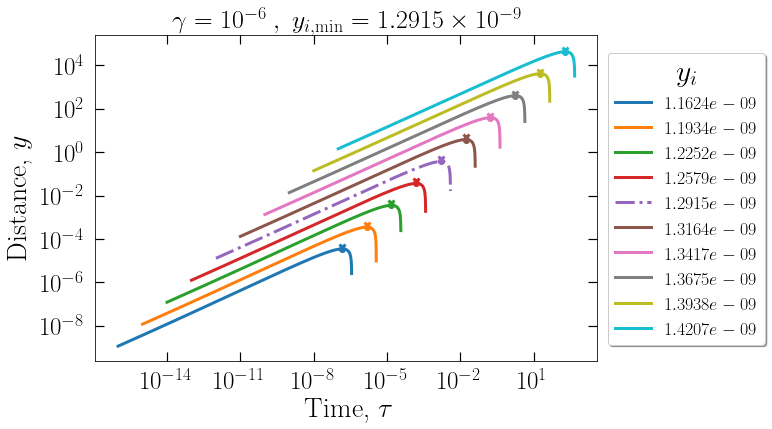

In [20]:
gamma = 1e-6
y_i_ref = 1.2915e-09
tau_i, tau_f = 1e-16, 1e15
gamma_values = np.geomspace(1e-10, 1, 5)

 
#yi_arr = np.array([0.9*y_i_ref, 0.95*y_i_ref, 0.99*y_i_ref,  
                   #y_i_ref, 1.01*y_i_ref, 1.05*y_i_ref, 1.1*y_i_ref])

    
yi_1 = 0.9*y_i_ref
yi_2 = 1.1*y_i_ref

yi_arr1 = np.geomspace(yi_1, y_i_ref, 5)

yi_arr2 = np.geomspace(y_i_ref, yi_2, 6)

sliced_yi_arr2 = yi_arr2[1:6]
#print(sliced_yi_arr2)
yi_arr = np.append(yi_arr1, sliced_yi_arr2)

fig, ax = plt.subplots(1, figsize = (9, 6))
plt.rc('lines', linewidth = 3)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')




colors = [ 'C0','C1','C2','C3','C4','C5', 'C6', 'C7', 'C8', 'C9']
marker_handles = []
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])

    
    if i == 4:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$', ls ='-.')
    else:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$')

    
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        yta_analytic = r_turnaround_full(tauta_numerical, gamma)
        print( "y_i =", '%0.4e'%y_i , ",",  "tau_ta_numerical =", '%0.4e'%tauta_numerical, ",", "yta_numerical =", '%0.4e'%yta_numerical, ",", "yta_analytic =", '%0.4e'%yta_analytic)
            
        yta_numerical_marker = ax.scatter(tauta_numerical* (10**i), yta_numerical* (10**i),color=color, zorder=1  )
        yta_analytic_marker = ax.scatter(tauta_numerical* (10**i), yta_analytic* (10**i), color=color,  marker='x',  zorder=9)
        if i == 0:
            marker_handles.append((yta_numerical_marker, "Numerical "))
            marker_handles.append((yta_analytic_marker, "Analytic"))

if len(marker_handles) == 2:  
    legend1 = plt.legend(
        handles=[marker_handles[0][0], marker_handles[1][0]],
        labels=[marker_handles[0][1], marker_handles[1][1]],prop={'size':16.2},
        loc=(1.02, 0.58), title=r'$y_\mathrm{ta}$', title_fontsize= 29, fontsize=12)
    #ax.add_artist(legend1)


lines = ax.get_lines()
legend2 = plt.legend( prop={'size':18}, 
                     loc=(1.02, 0.05), shadow=True, title='$y_{i}$', title_fontsize= 30,
    facecolor='white', fontsize=12)


ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


#plt.text(tau_i, 1e-4, r'$\gamma = 3.6\times 10^{-5}$', fontsize = 25)
#plt.text(tau_i, 1e-6, r'$\tau_i = 10^{-28}$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28, labelpad=9)
plt.title(r'$\gamma = 10^{-6}\; , \; y_{i, \mathrm{min}} =  1.2915 \times 10^{-9}$', fontsize= 26)
plt.savefig('yta_min15.pdf', bbox_inches='tight')

plt.show()

y_i = 1.1624e-09 , tau_ta_numerical = 5.6238e-01 , yta_numerical = 8.6600e-01 , yta_analytic = 1.0815e+00
y_i = 1.1934e-09 , tau_ta_numerical = 4.6459e-01 , yta_numerical = 7.6239e-01 , yta_analytic = 9.5220e-01
y_i = 1.2252e-09 , tau_ta_numerical = 3.8337e-01 , yta_numerical = 6.7065e-01 , yta_analytic = 8.3770e-01
y_i = 1.2579e-09 , tau_ta_numerical = 3.1678e-01 , yta_numerical = 5.9050e-01 , yta_analytic = 7.3765e-01
y_i = 1.2915e-09 , tau_ta_numerical = 2.5592e-01 , yta_numerical = 5.1215e-01 , yta_analytic = 6.3985e-01
y_i = 1.3164e-09 , tau_ta_numerical = 2.2480e-01 , yta_numerical = 4.6972e-01 , yta_analytic = 5.8687e-01
y_i = 1.3417e-09 , tau_ta_numerical = 1.9633e-01 , yta_numerical = 4.2914e-01 , yta_analytic = 5.3621e-01
y_i = 1.3675e-09 , tau_ta_numerical = 1.7141e-01 , yta_numerical = 3.9199e-01 , yta_analytic = 4.8982e-01
y_i = 1.3938e-09 , tau_ta_numerical = 1.4952e-01 , yta_numerical = 3.5783e-01 , yta_analytic = 4.4716e-01
y_i = 1.4207e-09 , tau_ta_numerical = 1.3033e-

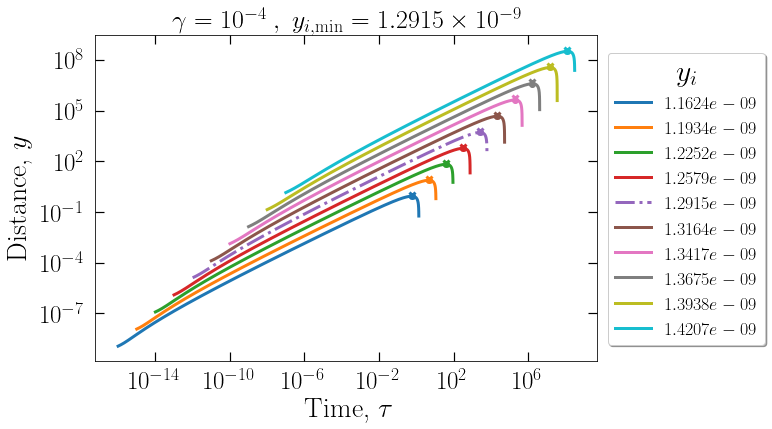

In [21]:
gamma = 1e-4
y_i_ref = 1.2915e-09
tau_i, tau_f = 1e-16, 1e15
gamma_values = np.geomspace(1e-10, 1, 5)

 
#yi_arr = np.array([0.9*y_i_ref, 0.95*y_i_ref, 0.99*y_i_ref,  
                   #y_i_ref, 1.01*y_i_ref, 1.05*y_i_ref, 1.1*y_i_ref])

    
yi_1 = 0.9*y_i_ref
yi_2 = 1.1*y_i_ref

yi_arr1 = np.geomspace(yi_1, y_i_ref, 5)

yi_arr2 = np.geomspace(y_i_ref, yi_2, 6)

sliced_yi_arr2 = yi_arr2[1:6]
#print(sliced_yi_arr2)
yi_arr = np.append(yi_arr1, sliced_yi_arr2)

fig, ax = plt.subplots(1, figsize = (9, 6))
plt.rc('lines', linewidth = 3)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')



colors = [ 'C0','C1','C2','C3','C4','C5', 'C6', 'C7', 'C8', 'C9']
marker_handles = []
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])

    
    if i == 4:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$', ls ='-.')
    else:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$')

    
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        yta_analytic = r_turnaround_full(tauta_numerical, gamma)
        print( "y_i =", '%0.4e'%y_i , ",",  "tau_ta_numerical =", '%0.4e'%tauta_numerical, ",", "yta_numerical =", '%0.4e'%yta_numerical, ",", "yta_analytic =", '%0.4e'%yta_analytic)
            
        yta_numerical_marker = ax.scatter(tauta_numerical* (10**i), yta_numerical* (10**i),color=color, zorder=1  )
        yta_analytic_marker = ax.scatter(tauta_numerical* (10**i), yta_analytic* (10**i), color=color,  marker='x',  zorder=9)
        if i == 0:
            marker_handles.append((yta_numerical_marker, "Numerical "))
            marker_handles.append((yta_analytic_marker, "Analytic"))

if len(marker_handles) == 2:  
    legend1 = plt.legend(
        handles=[marker_handles[0][0], marker_handles[1][0]],
        labels=[marker_handles[0][1], marker_handles[1][1]],prop={'size':16.2},
        loc=(1.02, 0.58), title=r'$y_\mathrm{ta}$', title_fontsize= 29, fontsize=12)
    #ax.add_artist(legend1)


lines = ax.get_lines()
legend2 = plt.legend( prop={'size':18}, 
                     loc=(1.02, 0.05), shadow=True, title='$y_{i}$', title_fontsize= 30,
    facecolor='white', fontsize=12)


ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


#plt.text(tau_i, 1e-4, r'$\gamma = 3.6\times 10^{-5}$', fontsize = 25)
#plt.text(tau_i, 1e-6, r'$\tau_i = 10^{-28}$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28, labelpad=9)
plt.title(r'$\gamma = 10^{-4}\; , \; y_{i, \mathrm{min}} =  1.2915 \times 10^{-9}$', fontsize= 26)
plt.savefig('yta_min16.pdf', bbox_inches='tight')

plt.show()

y_i = 1.9390e-08 , tau_ta_numerical = 1.1266e+00 , yta_numerical = 1.3927e+00 , yta_analytic = 1.7171e+00
y_i = 1.9907e-08 , tau_ta_numerical = 1.2075e+00 , yta_numerical = 1.4592e+00 , yta_analytic = 1.7983e+00
y_i = 2.0438e-08 , tau_ta_numerical = 1.3024e+00 , yta_numerical = 1.5355e+00 , yta_analytic = 1.8915e+00
y_i = 2.0984e-08 , tau_ta_numerical = 1.4133e+00 , yta_numerical = 1.6222e+00 , yta_analytic = 1.9975e+00
y_i = 2.1544e-08 , tau_ta_numerical = 1.5426e+00 , yta_numerical = 1.7204e+00 , yta_analytic = 2.1176e+00
y_i = 2.1959e-08 , tau_ta_numerical = 1.6490e+00 , yta_numerical = 1.7992e+00 , yta_analytic = 2.2140e+00
y_i = 2.2381e-08 , tau_ta_numerical = 1.7675e+00 , yta_numerical = 1.8849e+00 , yta_analytic = 2.3189e+00
y_i = 2.2812e-08 , tau_ta_numerical = 1.8993e+00 , yta_numerical = 1.9781e+00 , yta_analytic = 2.4329e+00
y_i = 2.3251e-08 , tau_ta_numerical = 2.0461e+00 , yta_numerical = 2.0793e+00 , yta_analytic = 2.5567e+00
y_i = 2.3698e-08 , tau_ta_numerical = 2.2093e+

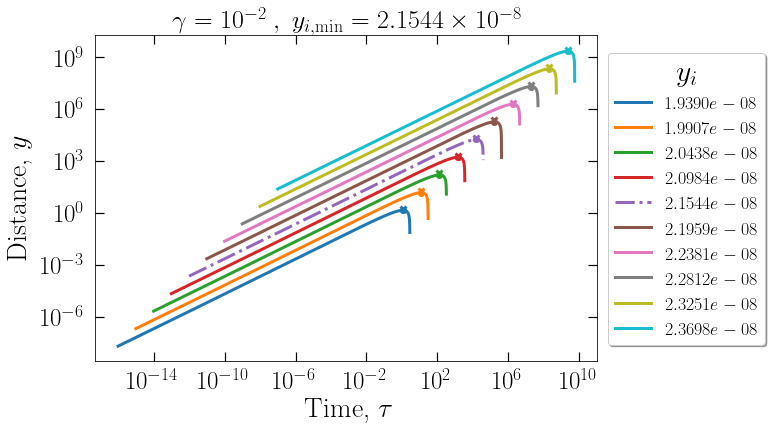

In [22]:
gamma = 1e-2
y_i_ref = 2.1544e-08
tau_i, tau_f = 1e-16, 1e15
gamma_values = np.geomspace(1e-10, 1, 5)

 
#yi_arr = np.array([0.9*y_i_ref, 0.95*y_i_ref, 0.99*y_i_ref,  
                   #y_i_ref, 1.01*y_i_ref, 1.05*y_i_ref, 1.1*y_i_ref])

    
yi_1 = 0.9*y_i_ref
yi_2 = 1.1*y_i_ref

yi_arr1 = np.geomspace(yi_1, y_i_ref, 5)

yi_arr2 = np.geomspace(y_i_ref, yi_2, 6)

sliced_yi_arr2 = yi_arr2[1:6]
#print(sliced_yi_arr2)
yi_arr = np.append(yi_arr1, sliced_yi_arr2)

fig, ax = plt.subplots(1, figsize = (9, 6))
plt.rc('lines', linewidth = 3)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')



colors = [ 'C0','C1','C2','C3','C4','C5', 'C6', 'C7', 'C8', 'C9']
marker_handles = []
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])

    
    if i == 4:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$', ls ='-.')
    else:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$')

    
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        yta_analytic = r_turnaround_full(tauta_numerical, gamma)
        print( "y_i =", '%0.4e'%y_i , ",",  "tau_ta_numerical =", '%0.4e'%tauta_numerical, ",", "yta_numerical =", '%0.4e'%yta_numerical, ",", "yta_analytic =", '%0.4e'%yta_analytic)
            
        yta_numerical_marker = ax.scatter(tauta_numerical* (10**i), yta_numerical* (10**i),color=color, zorder=1  )
        yta_analytic_marker = ax.scatter(tauta_numerical* (10**i), yta_analytic* (10**i), color=color,  marker='x',  zorder=9)
        if i == 0:
            marker_handles.append((yta_numerical_marker, "Numerical "))
            marker_handles.append((yta_analytic_marker, "Analytic"))

if len(marker_handles) == 2:  
    legend1 = plt.legend(
        handles=[marker_handles[0][0], marker_handles[1][0]],
        labels=[marker_handles[0][1], marker_handles[1][1]],prop={'size':16.2},
        loc=(1.02, 0.58), title=r'$y_\mathrm{ta}$', title_fontsize= 29, fontsize=12)
    #ax.add_artist(legend1)


lines = ax.get_lines()
legend2 = plt.legend( prop={'size':18}, 
                     loc=(1.02, 0.05), shadow=True, title='$y_{i}$', title_fontsize= 30,
    facecolor='white', fontsize=12)


ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


#plt.text(tau_i, 1e-4, r'$\gamma = 3.6\times 10^{-5}$', fontsize = 25)
#plt.text(tau_i, 1e-6, r'$\tau_i = 10^{-28}$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28, labelpad=9)
plt.title(r'$\gamma = 10^{-2}\; , \; y_{i, \mathrm{min}} = 2.1544 \times 10^{-8}$', fontsize= 26)
plt.savefig('yta_min17.pdf', bbox_inches='tight')

plt.show()

y_i = 1.9390e-08 , tau_ta_numerical = 1.7740e+04 , yta_numerical = 8.6844e+02 , yta_analytic = 1.0797e+03
y_i = 1.9907e-08 , tau_ta_numerical = 1.4953e+04 , yta_numerical = 7.7489e+02 , yta_analytic = 9.6339e+02
y_i = 2.0438e-08 , tau_ta_numerical = 1.2619e+04 , yta_numerical = 6.9197e+02 , yta_analytic = 8.6032e+02
y_i = 2.0984e-08 , tau_ta_numerical = 1.0671e+04 , yta_numerical = 6.1877e+02 , yta_analytic = 7.6931e+02
y_i = 2.1544e-08 , tau_ta_numerical = 9.0318e+03 , yta_numerical = 5.5367e+02 , yta_analytic = 6.8836e+02
y_i = 2.1959e-08 , tau_ta_numerical = 8.0137e+03 , yta_numerical = 5.1124e+02 , yta_analytic = 6.3560e+02
y_i = 2.2381e-08 , tau_ta_numerical = 7.1175e+03 , yta_numerical = 4.7238e+02 , yta_analytic = 5.8728e+02
y_i = 2.2812e-08 , tau_ta_numerical = 6.3283e+03 , yta_numerical = 4.3678e+02 , yta_analytic = 5.4302e+02
y_i = 2.3251e-08 , tau_ta_numerical = 5.6332e+03 , yta_numerical = 4.0418e+02 , yta_analytic = 5.0248e+02
y_i = 2.3698e-08 , tau_ta_numerical = 5.0207e+

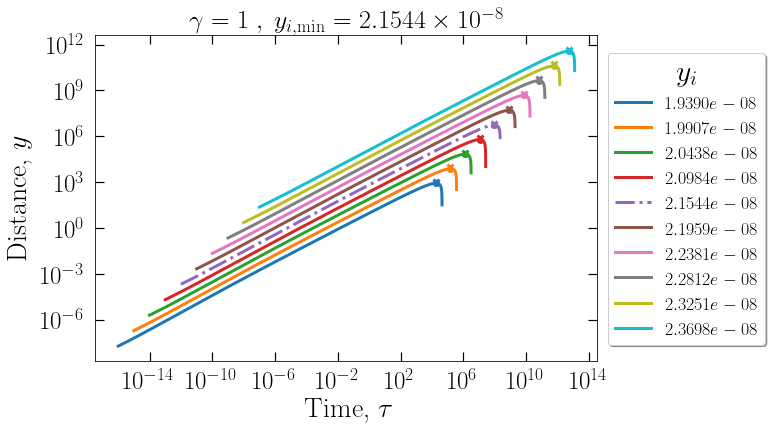

In [23]:
gamma = 1
y_i_ref = 2.1544e-08
tau_i, tau_f = 1e-16, 1e15
gamma_values = np.geomspace(1e-10, 1, 5)

 
#yi_arr = np.array([0.9*y_i_ref, 0.95*y_i_ref, 0.99*y_i_ref,  
                   #y_i_ref, 1.01*y_i_ref, 1.05*y_i_ref, 1.1*y_i_ref])

    
yi_1 = 0.9*y_i_ref
yi_2 = 1.1*y_i_ref

yi_arr1 = np.geomspace(yi_1, y_i_ref, 5)

yi_arr2 = np.geomspace(y_i_ref, yi_2, 6)

sliced_yi_arr2 = yi_arr2[1:6]
#print(sliced_yi_arr2)
yi_arr = np.append(yi_arr1, sliced_yi_arr2)

fig, ax = plt.subplots(1, figsize = (9, 6))
plt.rc('lines', linewidth = 3)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')



colors = [ 'C0','C1','C2','C3','C4','C5', 'C6', 'C7', 'C8', 'C9']
marker_handles = []
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])

    
    if i == 4:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$', ls ='-.')
    else:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$')

    
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        yta_analytic = r_turnaround_full(tauta_numerical, gamma)
        print( "y_i =", '%0.4e'%y_i , ",",  "tau_ta_numerical =", '%0.4e'%tauta_numerical, ",", "yta_numerical =", '%0.4e'%yta_numerical, ",", "yta_analytic =", '%0.4e'%yta_analytic)
            
        yta_numerical_marker = ax.scatter(tauta_numerical* (10**i), yta_numerical* (10**i),color=color, zorder=1  )
        yta_analytic_marker = ax.scatter(tauta_numerical* (10**i), yta_analytic* (10**i), color=color,  marker='x',  zorder=9)
        if i == 0:
            marker_handles.append((yta_numerical_marker, "Numerical "))
            marker_handles.append((yta_analytic_marker, "Analytic"))

if len(marker_handles) == 2:  
    legend1 = plt.legend(
        handles=[marker_handles[0][0], marker_handles[1][0]],
        labels=[marker_handles[0][1], marker_handles[1][1]],prop={'size':16.2},
        loc=(1.02, 0.58), title=r'$y_\mathrm{ta}$', title_fontsize= 29, fontsize=12)
    #ax.add_artist(legend1)


lines = ax.get_lines()
legend2 = plt.legend( prop={'size':18}, 
                     loc=(1.02, 0.05), shadow=True, title='$y_{i}$', title_fontsize= 30,
    facecolor='white', fontsize=12)


ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


#plt.text(tau_i, 1e-4, r'$\gamma = 3.6\times 10^{-5}$', fontsize = 25)
#plt.text(tau_i, 1e-6, r'$\tau_i = 10^{-28}$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28, labelpad=9)
plt.title(r'$\gamma = 1\; , \; y_{i, \mathrm{min}} = 2.1544 \times 10^{-8}$', fontsize= 26)
plt.savefig('yta_min18.pdf', bbox_inches='tight')

plt.show()

In [51]:
# y vs tau plots with spacings y_i = [0.5 y_i_min_ref - 1.5 yi_min_ref]

y_i = 3.8713e-11 , tau_ta_numerical = 1.2839e-15 , yta_numerical = 1.1312e-10 , yta_analytic = 1.6647e-10
y_i = 4.6038e-11 , tau_ta_numerical = 1.6569e-15 , yta_numerical = 1.3766e-10 , yta_analytic = 2.0219e-10
y_i = 5.4748e-11 , tau_ta_numerical = 2.4768e-15 , yta_numerical = 1.8291e-10 , yta_analytic = 2.7153e-10
y_i = 6.5107e-11 , tau_ta_numerical = 3.5819e-15 , yta_numerical = 2.6330e-10 , yta_analytic = 3.5318e-10
y_i = 7.7426e-11 , tau_ta_numerical = 6.2099e-15 , yta_numerical = 4.0056e-10 , yta_analytic = 5.1848e-10
y_i = 8.3966e-11 , tau_ta_numerical = 8.3816e-15 , yta_numerical = 4.9717e-10 , yta_analytic = 6.3740e-10
y_i = 9.1059e-11 , tau_ta_numerical = 1.1528e-14 , yta_numerical = 6.2347e-10 , yta_analytic = 7.9264e-10
y_i = 9.8751e-11 , tau_ta_numerical = 1.6180e-14 , yta_numerical = 7.9012e-10 , yta_analytic = 9.9824e-10
y_i = 1.0709e-10 , tau_ta_numerical = 2.3093e-14 , yta_numerical = 1.0113e-09 , yta_analytic = 1.2702e-09
y_i = 1.1614e-10 , tau_ta_numerical = 3.3472e-

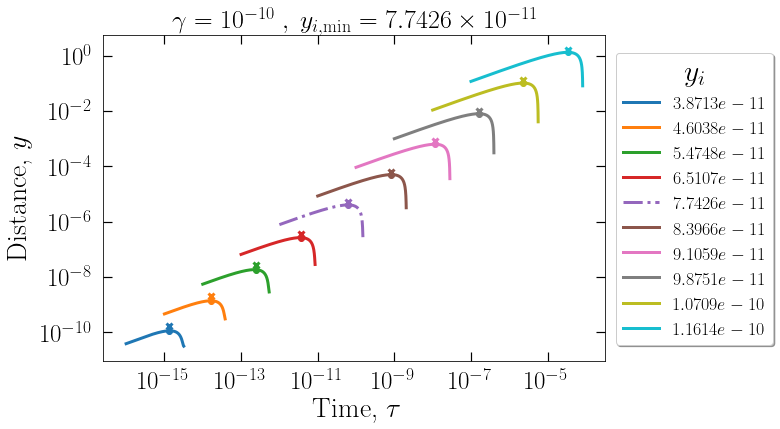

In [24]:
gamma = 1e-10
y_i_ref =7.7426e-11
tau_i, tau_f = 1e-16, 1e15
gamma_values = np.geomspace(1e-10, 1, 5)

 
#yi_arr = np.array([0.9*y_i_ref, 0.95*y_i_ref, 0.99*y_i_ref,  
                   #y_i_ref, 1.01*y_i_ref, 1.05*y_i_ref, 1.1*y_i_ref])

    
yi_1 = 0.5*y_i_ref
yi_2 = 1.5*y_i_ref

yi_arr1 = np.geomspace(yi_1, y_i_ref, 5)

yi_arr2 = np.geomspace(y_i_ref, yi_2, 6)

sliced_yi_arr2 = yi_arr2[1:6]
#print(sliced_yi_arr2)
yi_arr = np.append(yi_arr1, sliced_yi_arr2)

fig, ax = plt.subplots(1, figsize = (9, 6))
plt.rc('lines', linewidth = 3)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')






colors = [ 'C0','C1','C2','C3','C4','C5', 'C6', 'C7', 'C8', 'C9']
marker_handles = []
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])

    
    if i == 4:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$', ls ='-.')
    else:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$')

    
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        yta_analytic = r_turnaround_full(tauta_numerical, gamma)
        print( "y_i =", '%0.4e'%y_i , ",",  "tau_ta_numerical =", '%0.4e'%tauta_numerical, ",", "yta_numerical =", '%0.4e'%yta_numerical, ",", "yta_analytic =", '%0.4e'%yta_analytic)
            
        yta_numerical_marker = ax.scatter(tauta_numerical* (10**i), yta_numerical* (10**i),color=color, zorder=1  )
        yta_analytic_marker = ax.scatter(tauta_numerical* (10**i), yta_analytic* (10**i), color=color,  marker='x',  zorder=9)
        if i == 0:
            marker_handles.append((yta_numerical_marker, "Numerical "))
            marker_handles.append((yta_analytic_marker, "Analytic"))

if len(marker_handles) == 2:  
    legend1 = plt.legend(
        handles=[marker_handles[0][0], marker_handles[1][0]],
        labels=[marker_handles[0][1], marker_handles[1][1]],prop={'size':16.2},
        loc=(1.02, 0.58), title=r'$y_\mathrm{ta}$', title_fontsize= 29, fontsize=12)
    #ax.add_artist(legend1)


lines = ax.get_lines()
legend2 = plt.legend( prop={'size':18}, 
                     loc=(1.02, 0.05), shadow=True, title='$y_{i}$', title_fontsize= 30,
    facecolor='white', fontsize=12)


ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


#plt.text(tau_i, 1e-4, r'$\gamma = 3.6\times 10^{-5}$', fontsize = 25)
#plt.text(tau_i, 1e-6, r'$\tau_i = 10^{-28}$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28, labelpad=9)
plt.title(r'$\gamma = 10^{-10}\; , \; y_{i, \mathrm{min}} =  7.7426 \times 10^{-11}$', fontsize= 26)
plt.savefig('yta_min19.pdf', bbox_inches='tight')

plt.show()

y_i = 6.4575e-10 , tau_ta_numerical = 6.2800e-10 , yta_numerical = 9.4587e-07 , yta_analytic = 1.1624e-06
y_i = 7.6793e-10 , tau_ta_numerical = 1.6461e-09 , yta_numerical = 1.8021e-06 , yta_analytic = 2.2114e-06
y_i = 9.1323e-10 , tau_ta_numerical = 4.4523e-09 , yta_numerical = 3.5024e-06 , yta_analytic = 4.2945e-06
y_i = 1.0860e-09 , tau_ta_numerical = 1.2268e-08 , yta_numerical = 6.8882e-06 , yta_analytic = 8.4423e-06
y_i = 1.2915e-09 , tau_ta_numerical = 3.4176e-08 , yta_numerical = 1.3642e-05 , yta_analytic = 1.6716e-05
y_i = 1.4006e-09 , tau_ta_numerical = 5.5331e-08 , yta_numerical = 1.8811e-05 , yta_analytic = 2.3048e-05
y_i = 1.5189e-09 , tau_ta_numerical = 8.9675e-08 , yta_numerical = 2.5957e-05 , yta_analytic = 3.1801e-05
y_i = 1.6472e-09 , tau_ta_numerical = 1.4545e-07 , yta_numerical = 3.5835e-05 , yta_analytic = 4.3902e-05
y_i = 1.7864e-09 , tau_ta_numerical = 2.3607e-07 , yta_numerical = 4.9492e-05 , yta_analytic = 6.0632e-05
y_i = 1.9372e-09 , tau_ta_numerical = 3.8332e-

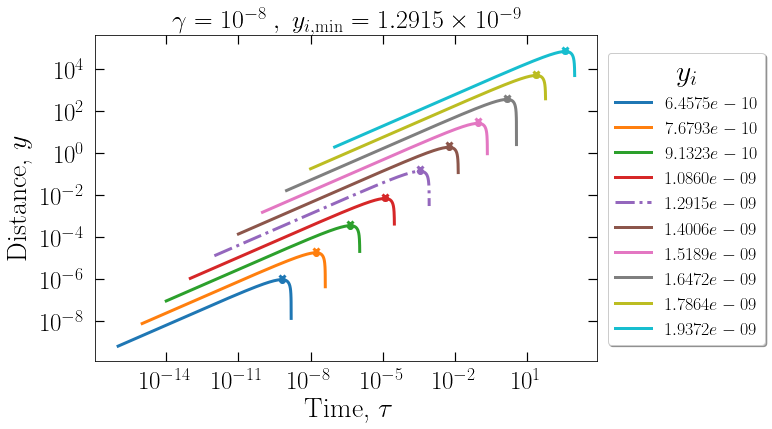

In [25]:
gamma = 1e-8
y_i_ref = 1.2915e-09
tau_i, tau_f = 1e-16, 1e15
gamma_values = np.geomspace(1e-10, 1, 5)

 
#yi_arr = np.array([0.9*y_i_ref, 0.95*y_i_ref, 0.99*y_i_ref,  
                   #y_i_ref, 1.01*y_i_ref, 1.05*y_i_ref, 1.1*y_i_ref])

    
yi_1 = 0.5*y_i_ref
yi_2 = 1.5*y_i_ref

yi_arr1 = np.geomspace(yi_1, y_i_ref, 5)

yi_arr2 = np.geomspace(y_i_ref, yi_2, 6)

sliced_yi_arr2 = yi_arr2[1:6]
#print(sliced_yi_arr2)
yi_arr = np.append(yi_arr1, sliced_yi_arr2)

fig, ax = plt.subplots(1, figsize = (9, 6))
plt.rc('lines', linewidth = 3)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')






colors = [ 'C0','C1','C2','C3','C4','C5', 'C6', 'C7', 'C8', 'C9']

marker_handles = []
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])

    
    if i == 4:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$', ls ='-.')
    else:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$')

    
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        yta_analytic = r_turnaround_full(tauta_numerical, gamma)
        print( "y_i =", '%0.4e'%y_i , ",",  "tau_ta_numerical =", '%0.4e'%tauta_numerical, ",", "yta_numerical =", '%0.4e'%yta_numerical, ",", "yta_analytic =", '%0.4e'%yta_analytic)
            
        yta_numerical_marker = ax.scatter(tauta_numerical* (10**i), yta_numerical* (10**i),color=color, zorder=1  )
        yta_analytic_marker = ax.scatter(tauta_numerical* (10**i), yta_analytic* (10**i), color=color,  marker='x',  zorder=9)
        if i == 0:
            marker_handles.append((yta_numerical_marker, "Numerical "))
            marker_handles.append((yta_analytic_marker, "Analytic"))

if len(marker_handles) == 2:  
    legend1 = plt.legend(
        handles=[marker_handles[0][0], marker_handles[1][0]],
        labels=[marker_handles[0][1], marker_handles[1][1]],prop={'size':16.2},
        loc=(1.02, 0.58), title=r'$y_\mathrm{ta}$', title_fontsize= 29, fontsize=12)
    #ax.add_artist(legend1)


lines = ax.get_lines()
legend2 = plt.legend( prop={'size':18}, 
                     loc=(1.02, 0.05), shadow=True, title='$y_{i}$', title_fontsize= 30,
    facecolor='white', fontsize=12)


ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


#plt.text(tau_i, 1e-4, r'$\gamma = 3.6\times 10^{-5}$', fontsize = 25)
#plt.text(tau_i, 1e-6, r'$\tau_i = 10^{-28}$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28, labelpad=9)
plt.title(r'$\gamma = 10^{-8}\; , \; y_{i, \mathrm{min}} =  1.2915 \times 10^{-9}$', fontsize= 26)
plt.savefig('yta_min20.pdf', bbox_inches='tight')

plt.show()

y_i = 6.4575e-10 , tau_ta_numerical = 1.2172e-06 , yta_numerical = 1.4345e-04 , yta_analytic = 1.8079e-04
y_i = 7.6793e-10 , tau_ta_numerical = 4.2895e-07 , yta_numerical = 7.1524e-05 , yta_analytic = 9.0120e-05
y_i = 9.1323e-10 , tau_ta_numerical = 2.0644e-07 , yta_numerical = 4.3967e-05 , yta_analytic = 5.5280e-05
y_i = 1.0860e-09 , tau_ta_numerical = 1.4771e-07 , yta_numerical = 3.5303e-05 , yta_analytic = 4.4190e-05
y_i = 1.2915e-09 , tau_ta_numerical = 1.5813e-07 , yta_numerical = 3.7166e-05 , yta_analytic = 4.6250e-05
y_i = 1.4006e-09 , tau_ta_numerical = 1.8430e-07 , yta_numerical = 4.1288e-05 , yta_analytic = 5.1241e-05
y_i = 1.5189e-09 , tau_ta_numerical = 2.2912e-07 , yta_numerical = 4.7875e-05 , yta_analytic = 5.9270e-05
y_i = 1.6472e-09 , tau_ta_numerical = 3.0082e-07 , yta_numerical = 5.7557e-05 , yta_analytic = 7.1100e-05
y_i = 1.7864e-09 , tau_ta_numerical = 4.1324e-07 , yta_numerical = 7.1288e-05 , yta_analytic = 8.7902e-05
y_i = 1.9372e-09 , tau_ta_numerical = 5.8897e-

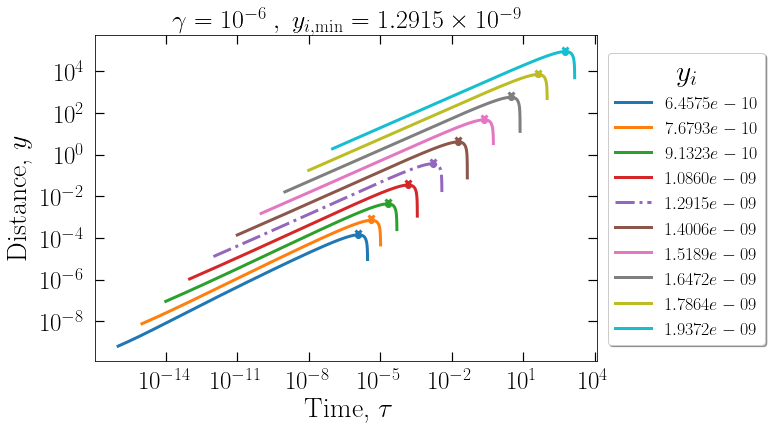

In [26]:
gamma = 1e-6
y_i_ref = 1.2915e-09
tau_i, tau_f = 1e-16, 1e15
gamma_values = np.geomspace(1e-10, 1, 5)

 
#yi_arr = np.array([0.9*y_i_ref, 0.95*y_i_ref, 0.99*y_i_ref,  
                   #y_i_ref, 1.01*y_i_ref, 1.05*y_i_ref, 1.1*y_i_ref])

    
yi_1 = 0.5*y_i_ref
yi_2 = 1.5*y_i_ref

yi_arr1 = np.geomspace(yi_1, y_i_ref, 5)

yi_arr2 = np.geomspace(y_i_ref, yi_2, 6)

sliced_yi_arr2 = yi_arr2[1:6]
#print(sliced_yi_arr2)
yi_arr = np.append(yi_arr1, sliced_yi_arr2)

fig, ax = plt.subplots(1, figsize = (9, 6))
plt.rc('lines', linewidth = 3)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')


colors = [ 'C0','C1','C2','C3','C4','C5', 'C6', 'C7', 'C8', 'C9']
marker_handles = []
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])

    
    if i == 4:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$', ls ='-.')
    else:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$')

    
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        yta_analytic = r_turnaround_full(tauta_numerical, gamma)
        print( "y_i =", '%0.4e'%y_i , ",",  "tau_ta_numerical =", '%0.4e'%tauta_numerical, ",", "yta_numerical =", '%0.4e'%yta_numerical, ",", "yta_analytic =", '%0.4e'%yta_analytic)
            
        yta_numerical_marker = ax.scatter(tauta_numerical* (10**i), yta_numerical* (10**i),color=color, zorder=1  )
        yta_analytic_marker = ax.scatter(tauta_numerical* (10**i), yta_analytic* (10**i), color=color,  marker='x',  zorder=9)
        if i == 0:
            marker_handles.append((yta_numerical_marker, "Numerical "))
            marker_handles.append((yta_analytic_marker, "Analytic"))

if len(marker_handles) == 2:  
    legend1 = plt.legend(
        handles=[marker_handles[0][0], marker_handles[1][0]],
        labels=[marker_handles[0][1], marker_handles[1][1]],prop={'size':16.2},
        loc=(1.02, 0.58), title=r'$y_\mathrm{ta}$', title_fontsize= 29, fontsize=12)
    #ax.add_artist(legend1)


lines = ax.get_lines()
legend2 = plt.legend( prop={'size':18}, 
                     loc=(1.02, 0.05), shadow=True, title='$y_{i}$', title_fontsize= 30,
    facecolor='white', fontsize=12)


ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


#plt.text(tau_i, 1e-4, r'$\gamma = 3.6\times 10^{-5}$', fontsize = 25)
#plt.text(tau_i, 1e-6, r'$\tau_i = 10^{-28}$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28, labelpad=9)
plt.title(r'$\gamma = 10^{-6}\; , \; y_{i, \mathrm{min}} =  1.2915 \times 10^{-9}$', fontsize= 26)
plt.savefig('yta_min21.pdf', bbox_inches='tight')

plt.show()

y_i = 6.4575e-10 , tau_ta_numerical = 3.8791e+01 , yta_numerical = 1.4594e+01 , yta_analytic = 1.8190e+01
y_i = 7.6793e-10 , tau_ta_numerical = 1.1230e+01 , yta_numerical = 6.3832e+00 , yta_analytic = 7.9606e+00
y_i = 9.1323e-10 , tau_ta_numerical = 3.2271e+00 , yta_numerical = 2.7781e+00 , yta_analytic = 3.4665e+00
y_i = 1.0860e-09 , tau_ta_numerical = 9.2108e-01 , yta_numerical = 1.2036e+00 , yta_analytic = 1.5027e+00
y_i = 1.2915e-09 , tau_ta_numerical = 2.5592e-01 , yta_numerical = 5.1215e-01 , yta_analytic = 6.3985e-01
y_i = 1.4006e-09 , tau_ta_numerical = 1.4439e-01 , yta_numerical = 3.4960e-01 , yta_analytic = 4.3689e-01
y_i = 1.5189e-09 , tau_ta_numerical = 8.0394e-02 , yta_numerical = 2.3653e-01 , yta_analytic = 2.9567e-01
y_i = 1.6472e-09 , tau_ta_numerical = 4.4795e-02 , yta_numerical = 1.6011e-01 , yta_analytic = 2.0020e-01
y_i = 1.7864e-09 , tau_ta_numerical = 2.5094e-02 , yta_numerical = 1.0877e-01 , yta_analytic = 1.3604e-01
y_i = 1.9372e-09 , tau_ta_numerical = 1.4159e-

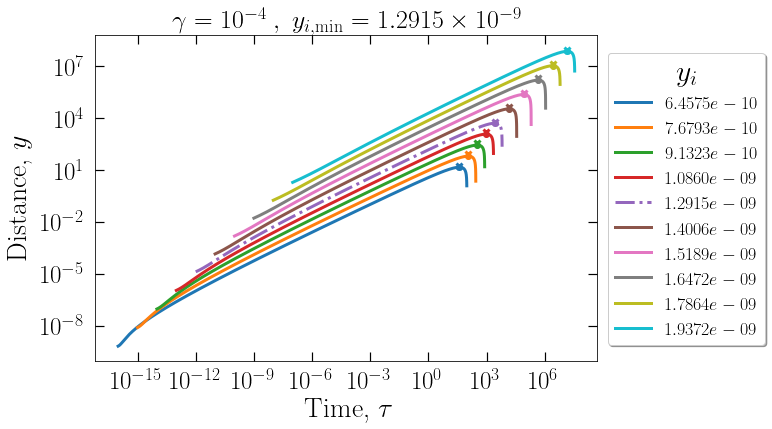

In [27]:
gamma = 1e-4
y_i_ref = 1.2915e-09
tau_i, tau_f = 1e-16, 1e15
gamma_values = np.geomspace(1e-10, 1, 5)

 
#yi_arr = np.array([0.9*y_i_ref, 0.95*y_i_ref, 0.99*y_i_ref,  
                   #y_i_ref, 1.01*y_i_ref, 1.05*y_i_ref, 1.1*y_i_ref])

    
yi_1 = 0.5*y_i_ref
yi_2 = 1.5*y_i_ref

yi_arr1 = np.geomspace(yi_1, y_i_ref, 5)

yi_arr2 = np.geomspace(y_i_ref, yi_2, 6)

sliced_yi_arr2 = yi_arr2[1:6]
#print(sliced_yi_arr2)
yi_arr = np.append(yi_arr1, sliced_yi_arr2)

fig, ax = plt.subplots(1, figsize = (9, 6))
plt.rc('lines', linewidth = 3)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')



colors = [ 'C0','C1','C2','C3','C4','C5', 'C6', 'C7', 'C8', 'C9']
marker_handles = []
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])

    
    if i == 4:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$', ls ='-.')
    else:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$')

    
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        yta_analytic = r_turnaround_full(tauta_numerical, gamma)
        print( "y_i =", '%0.4e'%y_i , ",",  "tau_ta_numerical =", '%0.4e'%tauta_numerical, ",", "yta_numerical =", '%0.4e'%yta_numerical, ",", "yta_analytic =", '%0.4e'%yta_analytic)
            
        yta_numerical_marker = ax.scatter(tauta_numerical* (10**i), yta_numerical* (10**i),color=color, zorder=1  )
        yta_analytic_marker = ax.scatter(tauta_numerical* (10**i), yta_analytic* (10**i), color=color,  marker='x',  zorder=9)
        if i == 0:
            marker_handles.append((yta_numerical_marker, "Numerical "))
            marker_handles.append((yta_analytic_marker, "Analytic"))

if len(marker_handles) == 2:  
    legend1 = plt.legend(
        handles=[marker_handles[0][0], marker_handles[1][0]],
        labels=[marker_handles[0][1], marker_handles[1][1]],prop={'size':16.2},
        loc=(1.02, 0.58), title=r'$y_\mathrm{ta}$', title_fontsize= 29, fontsize=12)
    #ax.add_artist(legend1)


lines = ax.get_lines()
legend2 = plt.legend( prop={'size':18}, 
                     loc=(1.02, 0.05), shadow=True, title='$y_{i}$', title_fontsize= 30,
    facecolor='white', fontsize=12)


ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


#plt.text(tau_i, 1e-4, r'$\gamma = 3.6\times 10^{-5}$', fontsize = 25)
#plt.text(tau_i, 1e-6, r'$\tau_i = 10^{-28}$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28, labelpad=9)
plt.title(r'$\gamma = 10^{-4}\; , \; y_{i, \mathrm{min}} =  1.2915 \times 10^{-9}$', fontsize= 26)
plt.savefig('yta_min22.pdf', bbox_inches='tight')

plt.show()

y_i = 1.0772e-08 , tau_ta_numerical = 2.0064e+00 , yta_numerical = 2.0275e+00 , yta_analytic = 2.5236e+00
y_i = 1.2810e-08 , tau_ta_numerical = 1.0896e+00 , yta_numerical = 1.3518e+00 , yta_analytic = 1.6792e+00
y_i = 1.5234e-08 , tau_ta_numerical = 8.5042e-01 , yta_numerical = 1.1491e+00 , yta_analytic = 1.4232e+00
y_i = 1.8116e-08 , tau_ta_numerical = 9.7301e-01 , yta_numerical = 1.2614e+00 , yta_analytic = 1.5571e+00
y_i = 2.1544e-08 , tau_ta_numerical = 1.5426e+00 , yta_numerical = 1.7204e+00 , yta_analytic = 2.1176e+00
y_i = 2.3364e-08 , tau_ta_numerical = 2.0859e+00 , yta_numerical = 2.1064e+00 , yta_analytic = 2.5898e+00
y_i = 2.5337e-08 , tau_ta_numerical = 2.9409e+00 , yta_numerical = 2.6511e+00 , yta_analytic = 3.2568e+00
y_i = 2.7478e-08 , tau_ta_numerical = 4.2868e+00 , yta_numerical = 3.4109e+00 , yta_analytic = 4.1873e+00
y_i = 2.9799e-08 , tau_ta_numerical = 6.4143e+00 , yta_numerical = 4.4650e+00 , yta_analytic = 5.4784e+00
y_i = 3.2316e-08 , tau_ta_numerical = 9.7942e+

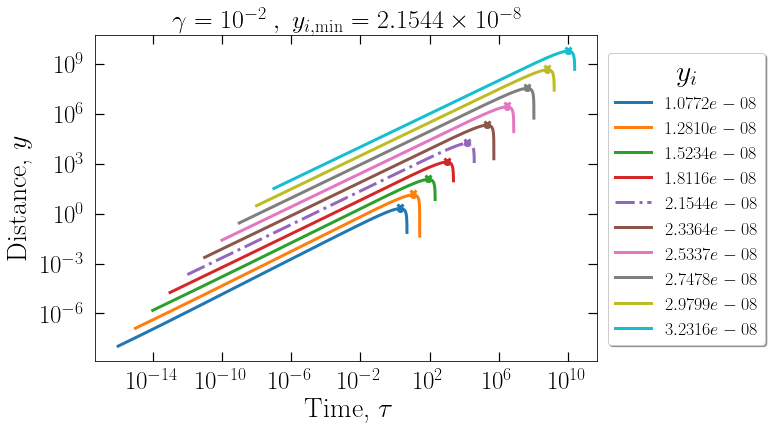

In [28]:
gamma = 1e-2
y_i_ref = 2.1544e-08
tau_i, tau_f = 1e-16, 1e15
gamma_values = np.geomspace(1e-10, 1, 5)

 
#yi_arr = np.array([0.9*y_i_ref, 0.95*y_i_ref, 0.99*y_i_ref,  
                   #y_i_ref, 1.01*y_i_ref, 1.05*y_i_ref, 1.1*y_i_ref])

    
yi_1 = 0.5*y_i_ref
yi_2 = 1.5*y_i_ref

yi_arr1 = np.geomspace(yi_1, y_i_ref, 5)

yi_arr2 = np.geomspace(y_i_ref, yi_2, 6)

sliced_yi_arr2 = yi_arr2[1:6]
#print(sliced_yi_arr2)
yi_arr = np.append(yi_arr1, sliced_yi_arr2)

fig, ax = plt.subplots(1, figsize = (9, 6))
plt.rc('lines', linewidth = 3)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')



colors = [ 'C0','C1','C2','C3','C4','C5', 'C6', 'C7', 'C8', 'C9']
marker_handles = []
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])

    
    if i == 4:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$', ls ='-.')
    else:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$')

    
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        yta_analytic = r_turnaround_full(tauta_numerical, gamma)
        print( "y_i =", '%0.4e'%y_i , ",",  "tau_ta_numerical =", '%0.4e'%tauta_numerical, ",", "yta_numerical =", '%0.4e'%yta_numerical, ",", "yta_analytic =", '%0.4e'%yta_analytic)
            
        yta_numerical_marker = ax.scatter(tauta_numerical* (10**i), yta_numerical* (10**i),color=color, zorder=1  )
        yta_analytic_marker = ax.scatter(tauta_numerical* (10**i), yta_analytic* (10**i), color=color,  marker='x',  zorder=9)
        if i == 0:
            marker_handles.append((yta_numerical_marker, "Numerical "))
            marker_handles.append((yta_analytic_marker, "Analytic"))

if len(marker_handles) == 2:  
    legend1 = plt.legend(
        handles=[marker_handles[0][0], marker_handles[1][0]],
        labels=[marker_handles[0][1], marker_handles[1][1]],prop={'size':16.2},
        loc=(1.02, 0.58), title=r'$y_\mathrm{ta}$', title_fontsize= 29, fontsize=12)
    #ax.add_artist(legend1)


lines = ax.get_lines()
legend2 = plt.legend( prop={'size':18}, 
                     loc=(1.02, 0.05), shadow=True, title='$y_{i}$', title_fontsize= 30,
    facecolor='white', fontsize=12)


ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


#plt.text(tau_i, 1e-4, r'$\gamma = 3.6\times 10^{-5}$', fontsize = 25)
#plt.text(tau_i, 1e-6, r'$\tau_i = 10^{-28}$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28, labelpad=9)
plt.title(r'$\gamma = 10^{-2}\; , \; y_{i, \mathrm{min}} = 2.1544 \times 10^{-8}$', fontsize= 26)
plt.savefig('yta_min23.pdf', bbox_inches='tight')

plt.show()

y_i = 1.0772e-08 , tau_ta_numerical = 9.1080e+05 , yta_numerical = 1.2007e+04 , yta_analytic = 1.4915e+04
y_i = 1.2810e-08 , tau_ta_numerical = 2.8635e+05 , yta_numerical = 5.5499e+03 , yta_analytic = 6.8962e+03
y_i = 1.5234e-08 , tau_ta_numerical = 8.8358e+04 , yta_numerical = 2.5335e+03 , yta_analytic = 3.1490e+03
y_i = 1.8116e-08 , tau_ta_numerical = 2.7667e+04 , yta_numerical = 1.1680e+03 , yta_analytic = 1.4520e+03
y_i = 2.1544e-08 , tau_ta_numerical = 9.0318e+03 , yta_numerical = 5.5367e+02 , yta_analytic = 6.8836e+02
y_i = 2.3364e-08 , tau_ta_numerical = 5.4701e+03 , yta_numerical = 3.9634e+02 , yta_analytic = 4.9273e+02
y_i = 2.5337e-08 , tau_ta_numerical = 3.3906e+03 , yta_numerical = 2.8815e+02 , yta_analytic = 3.5818e+02
y_i = 2.7478e-08 , tau_ta_numerical = 2.1682e+03 , yta_numerical = 2.1392e+02 , yta_analytic = 2.6584e+02
y_i = 2.9799e-08 , tau_ta_numerical = 1.4442e+03 , yta_numerical = 1.6321e+02 , yta_analytic = 2.0274e+02
y_i = 3.2316e-08 , tau_ta_numerical = 1.0129e+

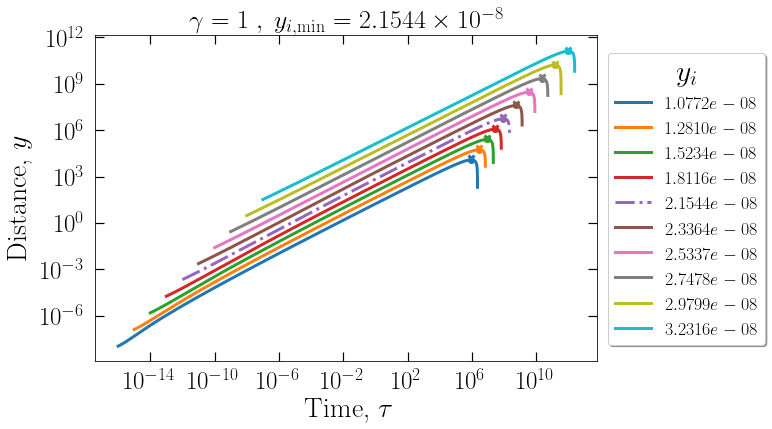

In [30]:
gamma = 1
y_i_ref = 2.1544e-08
tau_i, tau_f = 1e-16, 1e15
gamma_values = np.geomspace(1e-10, 1, 5)

 
#yi_arr = np.array([0.9*y_i_ref, 0.95*y_i_ref, 0.99*y_i_ref,  
                   #y_i_ref, 1.01*y_i_ref, 1.05*y_i_ref, 1.1*y_i_ref])

    
yi_1 = 0.5*y_i_ref
yi_2 = 1.5*y_i_ref

yi_arr1 = np.geomspace(yi_1, y_i_ref, 5)

yi_arr2 = np.geomspace(y_i_ref, yi_2, 6)

sliced_yi_arr2 = yi_arr2[1:6]
#print(sliced_yi_arr2)
yi_arr = np.append(yi_arr1, sliced_yi_arr2)

fig, ax = plt.subplots(1, figsize = (9, 6))
plt.rc('lines', linewidth = 3)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')



colors = [ 'C0','C1','C2','C3','C4','C5', 'C6', 'C7', 'C8', 'C9']
marker_handles = []
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])

    
    if i == 4:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$', ls ='-.')
    else:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$')

    
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        yta_analytic = r_turnaround_full(tauta_numerical, gamma)
        print( "y_i =", '%0.4e'%y_i , ",",  "tau_ta_numerical =", '%0.4e'%tauta_numerical, ",", "yta_numerical =", '%0.4e'%yta_numerical, ",", "yta_analytic =", '%0.4e'%yta_analytic)
            
        yta_numerical_marker = ax.scatter(tauta_numerical* (10**i), yta_numerical* (10**i),color=color, zorder=1  )
        yta_analytic_marker = ax.scatter(tauta_numerical* (10**i), yta_analytic* (10**i), color=color,  marker='x',  zorder=9)
        if i == 0:
            marker_handles.append((yta_numerical_marker, "Numerical "))
            marker_handles.append((yta_analytic_marker, "Analytic"))

if len(marker_handles) == 2:  
    legend1 = plt.legend(
        handles=[marker_handles[0][0], marker_handles[1][0]],
        labels=[marker_handles[0][1], marker_handles[1][1]],prop={'size':16.2},
        loc=(1.02, 0.58), title=r'$y_\mathrm{ta}$', title_fontsize= 29, fontsize=12)
    #ax.add_artist(legend1)


lines = ax.get_lines()
legend2 = plt.legend( prop={'size':18}, 
                     loc=(1.02, 0.05), shadow=True, title='$y_{i}$', title_fontsize= 30,
    facecolor='white', fontsize=12)


ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


#plt.text(tau_i, 1e-4, r'$\gamma = 3.6\times 10^{-5}$', fontsize = 25)
#plt.text(tau_i, 1e-6, r'$\tau_i = 10^{-28}$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28, labelpad=9)
plt.title(r'$\gamma = 1\; , \; y_{i, \mathrm{min}} = 2.1544 \times 10^{-8}$', fontsize= 26)
plt.savefig('yta_min24.pdf', bbox_inches='tight')

plt.show()

In [31]:
# plots of y vs tau with 
# y_i-spacings =  np.array([0.5*y_i_ref, 0.9*y_i_ref, 0.95*y_i_ref,
                  #  0.99*y_i_ref, y_i_ref, 1.01*y_i_ref, 
                  #    1.05*y_i_ref, 1.1*y_i_ref, , 1.5*y_i_ref])


y_i = 3.8713e-11 , tau_ta_numerical = 1.2839e-15 , yta_numerical = 1.1312e-10 , yta_analytic = 1.6647e-10
y_i = 6.9683e-11 , tau_ta_numerical = 4.3851e-15 , yta_numerical = 3.0830e-10 , yta_analytic = 4.0710e-10
y_i = 7.3555e-11 , tau_ta_numerical = 5.1791e-15 , yta_numerical = 3.5175e-10 , yta_analytic = 4.5718e-10
y_i = 7.6652e-11 , tau_ta_numerical = 5.9888e-15 , yta_numerical = 3.9035e-10 , yta_analytic = 5.0564e-10
y_i = 7.7426e-11 , tau_ta_numerical = 6.2099e-15 , yta_numerical = 4.0056e-10 , yta_analytic = 5.1848e-10
y_i = 7.8200e-11 , tau_ta_numerical = 6.4309e-15 , yta_numerical = 4.1101e-10 , yta_analytic = 5.3116e-10
y_i = 8.1297e-11 , tau_ta_numerical = 7.4145e-15 , yta_numerical = 4.5570e-10 , yta_analytic = 5.8591e-10
y_i = 8.5169e-11 , tau_ta_numerical = 8.8483e-15 , yta_numerical = 5.1689e-10 , yta_analytic = 6.6153e-10
y_i = 1.1614e-10 , tau_ta_numerical = 3.3472e-14 , yta_numerical = 1.3063e-09 , yta_analytic = 1.6317e-09


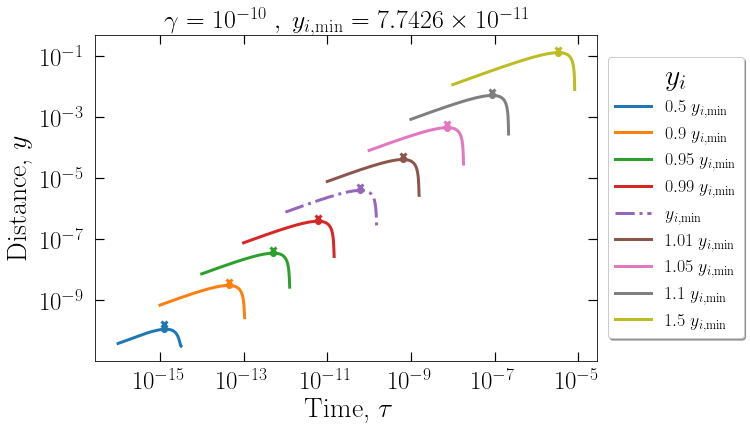

In [65]:
gamma = 1e-10
y_i_ref =7.7426e-11
tau_i, tau_f = 1e-16, 1e15
gamma_values = np.geomspace(1e-10, 1, 5)

 
yi_arr = np.array([0.5*y_i_ref, 0.9*y_i_ref, 0.95*y_i_ref, 0.99*y_i_ref,  
                   y_i_ref, 1.01*y_i_ref, 1.05*y_i_ref, 1.1*y_i_ref, 1.5*y_i_ref])




fig, ax = plt.subplots(1, figsize = (9, 6))
plt.rc('lines', linewidth = 3)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')






colors = [ 'C0','C1','C2','C3','C4','C5', 'C6', 'C7', 'C8']

marker_handles = []
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])

    
    if i == 4:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$', ls ='-.')
    else:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$')

    
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        yta_analytic = r_turnaround_full(tauta_numerical, gamma)
        print( "y_i =", '%0.4e'%y_i , ",",  "tau_ta_numerical =", '%0.4e'%tauta_numerical, ",", "yta_numerical =", '%0.4e'%yta_numerical, ",", "yta_analytic =", '%0.4e'%yta_analytic)
            
        yta_numerical_marker = ax.scatter(tauta_numerical* (10**i), yta_numerical* (10**i),color=color, zorder=1  )
        yta_analytic_marker = ax.scatter(tauta_numerical* (10**i), yta_analytic* (10**i), color=color,  marker='x',  zorder=9)
        if i == 0:
            marker_handles.append((yta_numerical_marker, "Numerical "))
            marker_handles.append((yta_analytic_marker, "Analytic"))

if len(marker_handles) == 2:  
    legend1 = plt.legend(
        handles=[marker_handles[0][0], marker_handles[1][0]],
        labels=[marker_handles[0][1], marker_handles[1][1]],prop={'size':16.2},
        loc=(1.02, 0.58), title=r'$y_\mathrm{ta}$', title_fontsize= 29, fontsize=12)
    #ax.add_artist(legend1)


lines = ax.get_lines()
legend2 = plt.legend([lines[i] for i in range(len(colors))], 
        [r"$0.5 \;y_{i, \mathrm{min}}$", r"$0.9 \;y_{i, \mathrm{min}}$", r"$0.95\; y_{i, \mathrm{min}}$", 
        r"$0.99\; y_{i, \mathrm{min}}$" , r"$ y_{i, \mathrm{min}}$", 
        r"$1.01\; y_{i, \mathrm{min}}$", r"$1.05\; y_{i, \mathrm{min}}$",
        r"$1.1 \;y_{i, \mathrm{min}}$", r"$1.5 \;y_{i, \mathrm{min}}$"], prop={'size':18}, 
                     
                     loc=(1.02, 0.07), shadow=True, title='$y_{i}$', title_fontsize= 30,
    facecolor='white', fontsize=12)


ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


#plt.text(tau_i, 1e-4, r'$\gamma = 3.6\times 10^{-5}$', fontsize = 25)
#plt.text(tau_i, 1e-6, r'$\tau_i = 10^{-28}$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28, labelpad=9)
plt.title(r'$\gamma = 10^{-10}\; , \; y_{i, \mathrm{min}} =  7.7426 \times 10^{-11}$', fontsize= 26)
plt.savefig('yta_min25.pdf', bbox_inches='tight')
plt.show()

y_i = 6.4575e-10 , tau_ta_numerical = 6.2800e-10 , yta_numerical = 9.4587e-07 , yta_analytic = 1.1624e-06
y_i = 1.1624e-09 , tau_ta_numerical = 1.8313e-08 , yta_numerical = 8.9984e-06 , yta_analytic = 1.1027e-05
y_i = 1.2269e-09 , tau_ta_numerical = 2.5215e-08 , yta_numerical = 1.1138e-05 , yta_analytic = 1.3648e-05
y_i = 1.2786e-09 , tau_ta_numerical = 3.2198e-08 , yta_numerical = 1.3110e-05 , yta_analytic = 1.6064e-05
y_i = 1.2915e-09 , tau_ta_numerical = 3.4176e-08 , yta_numerical = 1.3642e-05 , yta_analytic = 1.6716e-05
y_i = 1.3044e-09 , tau_ta_numerical = 3.6255e-08 , yta_numerical = 1.4190e-05 , yta_analytic = 1.7387e-05
y_i = 1.3561e-09 , tau_ta_numerical = 4.5663e-08 , yta_numerical = 1.6550e-05 , yta_analytic = 2.0278e-05
y_i = 1.4207e-09 , tau_ta_numerical = 6.0215e-08 , yta_numerical = 1.9903e-05 , yta_analytic = 2.4385e-05
y_i = 1.9372e-09 , tau_ta_numerical = 3.8332e-07 , yta_numerical = 6.8375e-05 , yta_analytic = 8.3763e-05


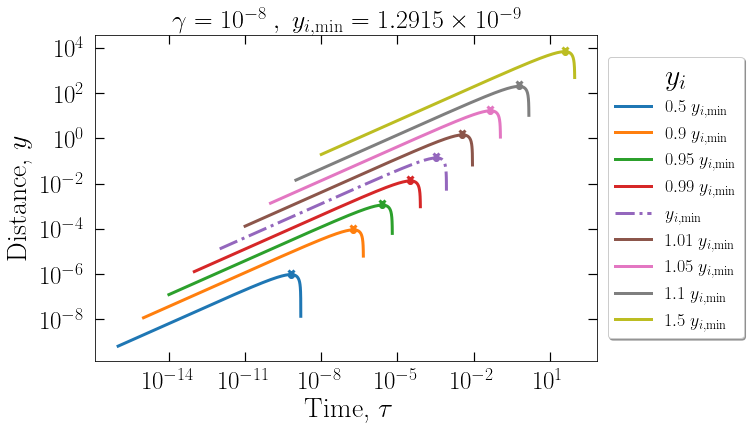

In [64]:
gamma = 1e-8
y_i_ref = 1.2915e-09
tau_i, tau_f = 1e-16, 1e15
gamma_values = np.geomspace(1e-10, 1, 5)

 
yi_arr = np.array([0.5*y_i_ref, 0.9*y_i_ref, 0.95*y_i_ref, 0.99*y_i_ref,  
                   y_i_ref, 1.01*y_i_ref, 1.05*y_i_ref, 1.1*y_i_ref, 1.5*y_i_ref])




fig, ax = plt.subplots(1, figsize = (9, 6))
plt.rc('lines', linewidth = 3)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')






colors = [ 'C0','C1','C2','C3','C4','C5', 'C6', 'C7', 'C8']

marker_handles = []
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])

    
    if i == 4:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$', ls ='-.')
    else:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$')

    
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        yta_analytic = r_turnaround_full(tauta_numerical, gamma)
        print( "y_i =", '%0.4e'%y_i , ",",  "tau_ta_numerical =", '%0.4e'%tauta_numerical, ",", "yta_numerical =", '%0.4e'%yta_numerical, ",", "yta_analytic =", '%0.4e'%yta_analytic)
            
        yta_numerical_marker = ax.scatter(tauta_numerical* (10**i), yta_numerical* (10**i),color=color, zorder=1  )
        yta_analytic_marker = ax.scatter(tauta_numerical* (10**i), yta_analytic* (10**i), color=color,  marker='x',  zorder=9)
        if i == 0:
            marker_handles.append((yta_numerical_marker, "Numerical "))
            marker_handles.append((yta_analytic_marker, "Analytic"))

if len(marker_handles) == 2:  
    legend1 = plt.legend(
        handles=[marker_handles[0][0], marker_handles[1][0]],
        labels=[marker_handles[0][1], marker_handles[1][1]],prop={'size':16.2},
        loc=(1.02, 0.58), title=r'$y_\mathrm{ta}$', title_fontsize= 29, fontsize=12)
    #ax.add_artist(legend1)


lines = ax.get_lines()
legend2 = plt.legend([lines[i] for i in range(len(colors))], 
        [r"$0.5 \;y_{i, \mathrm{min}}$", r"$0.9 \;y_{i, \mathrm{min}}$", r"$0.95\; y_{i, \mathrm{min}}$", 
        r"$0.99\; y_{i, \mathrm{min}}$" , r"$ y_{i, \mathrm{min}}$", 
        r"$1.01\; y_{i, \mathrm{min}}$", r"$1.05\; y_{i, \mathrm{min}}$",
        r"$1.1 \;y_{i, \mathrm{min}}$", r"$1.5 \;y_{i, \mathrm{min}}$"], prop={'size':18}, 
                     
                     loc=(1.02, 0.07), shadow=True, title='$y_{i}$', title_fontsize= 30,
    facecolor='white', fontsize=12)


ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


#plt.text(tau_i, 1e-4, r'$\gamma = 3.6\times 10^{-5}$', fontsize = 25)
#plt.text(tau_i, 1e-6, r'$\tau_i = 10^{-28}$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28, labelpad=9)
plt.title(r'$\gamma = 10^{-8}\; , \; y_{i, \mathrm{min}} =  1.2915 \times 10^{-9}$', fontsize= 26)
plt.savefig('yta_min26.pdf', bbox_inches='tight')

plt.show()

y_i = 6.4575e-10 , tau_ta_numerical = 1.2172e-06 , yta_numerical = 1.4345e-04 , yta_analytic = 1.8079e-04
y_i = 1.1624e-09 , tau_ta_numerical = 1.4496e-07 , yta_numerical = 3.4939e-05 , yta_analytic = 4.3636e-05
y_i = 1.2269e-09 , tau_ta_numerical = 1.4904e-07 , yta_numerical = 3.5660e-05 , yta_analytic = 4.4455e-05
y_i = 1.2786e-09 , tau_ta_numerical = 1.5593e-07 , yta_numerical = 3.6807e-05 , yta_analytic = 4.5819e-05
y_i = 1.2915e-09 , tau_ta_numerical = 1.5813e-07 , yta_numerical = 3.7166e-05 , yta_analytic = 4.6250e-05
y_i = 1.3044e-09 , tau_ta_numerical = 1.6051e-07 , yta_numerical = 3.7553e-05 , yta_analytic = 4.6717e-05
y_i = 1.3561e-09 , tau_ta_numerical = 1.7196e-07 , yta_numerical = 3.9376e-05 , yta_analytic = 4.8920e-05
y_i = 1.4207e-09 , tau_ta_numerical = 1.9063e-07 , yta_numerical = 4.2251e-05 , yta_analytic = 5.2412e-05
y_i = 1.9372e-09 , tau_ta_numerical = 5.8897e-07 , yta_numerical = 9.0456e-05 , yta_analytic = 1.1137e-04


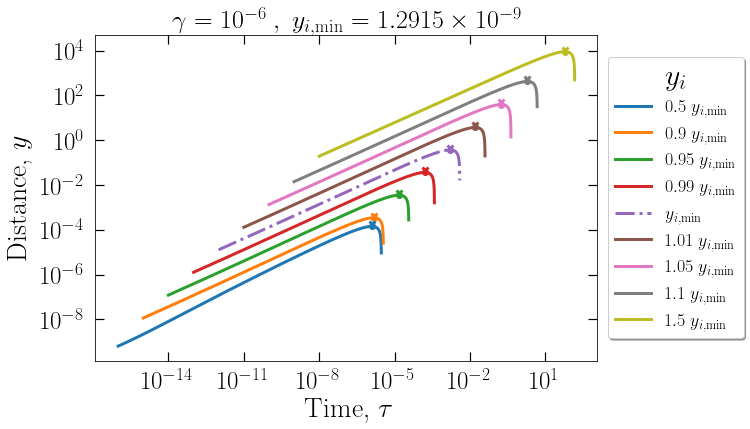

In [63]:
gamma = 1e-6
y_i_ref = 1.2915e-09
tau_i, tau_f = 1e-16, 1e15
gamma_values = np.geomspace(1e-10, 1, 5)

 
 
yi_arr = np.array([0.5*y_i_ref, 0.9*y_i_ref, 0.95*y_i_ref, 0.99*y_i_ref,  
                   y_i_ref, 1.01*y_i_ref, 1.05*y_i_ref, 1.1*y_i_ref, 1.5*y_i_ref])




fig, ax = plt.subplots(1, figsize = (9, 6))
plt.rc('lines', linewidth = 3)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')






colors = [ 'C0','C1','C2','C3','C4','C5', 'C6', 'C7', 'C8']

marker_handles = []
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])

    
    if i == 4:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$', ls ='-.')
    else:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$')

    
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        yta_analytic = r_turnaround_full(tauta_numerical, gamma)
        print( "y_i =", '%0.4e'%y_i , ",",  "tau_ta_numerical =", '%0.4e'%tauta_numerical, ",", "yta_numerical =", '%0.4e'%yta_numerical, ",", "yta_analytic =", '%0.4e'%yta_analytic)
            
        yta_numerical_marker = ax.scatter(tauta_numerical* (10**i), yta_numerical* (10**i),color=color, zorder=1  )
        yta_analytic_marker = ax.scatter(tauta_numerical* (10**i), yta_analytic* (10**i), color=color,  marker='x',  zorder=9)
        if i == 0:
            marker_handles.append((yta_numerical_marker, "Numerical "))
            marker_handles.append((yta_analytic_marker, "Analytic"))

if len(marker_handles) == 2:  
    legend1 = plt.legend(
        handles=[marker_handles[0][0], marker_handles[1][0]],
        labels=[marker_handles[0][1], marker_handles[1][1]],prop={'size':16.2},
        loc=(1.02, 0.58), title=r'$y_\mathrm{ta}$', title_fontsize= 29, fontsize=12)
    #ax.add_artist(legend1)


lines = ax.get_lines()
legend2 = plt.legend([lines[i] for i in range(len(colors))], 
        [r"$0.5 \;y_{i, \mathrm{min}}$", r"$0.9 \;y_{i, \mathrm{min}}$", r"$0.95\; y_{i, \mathrm{min}}$", 
        r"$0.99\; y_{i, \mathrm{min}}$" , r"$ y_{i, \mathrm{min}}$", 
        r"$1.01\; y_{i, \mathrm{min}}$", r"$1.05\; y_{i, \mathrm{min}}$",
        r"$1.1 \;y_{i, \mathrm{min}}$", r"$1.5 \;y_{i, \mathrm{min}}$"], prop={'size':18}, 
                     
                     loc=(1.02, 0.07), shadow=True, title='$y_{i}$', title_fontsize= 30,
    facecolor='white', fontsize=12)


ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


#plt.text(tau_i, 1e-4, r'$\gamma = 3.6\times 10^{-5}$', fontsize = 25)
#plt.text(tau_i, 1e-6, r'$\tau_i = 10^{-28}$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28, labelpad=9)
plt.title(r'$\gamma = 10^{-6}\; , \; y_{i, \mathrm{min}} =  1.2915 \times 10^{-9}$', fontsize= 26)
plt.savefig('yta_min27.pdf', bbox_inches='tight')

plt.show()

y_i = 6.4575e-10 , tau_ta_numerical = 3.8791e+01 , yta_numerical = 1.4594e+01 , yta_analytic = 1.8190e+01
y_i = 1.1624e-09 , tau_ta_numerical = 5.6238e-01 , yta_numerical = 8.6600e-01 , yta_analytic = 1.0815e+00
y_i = 1.2269e-09 , tau_ta_numerical = 3.7963e-01 , yta_numerical = 6.6628e-01 , yta_analytic = 8.3225e-01
y_i = 1.2786e-09 , tau_ta_numerical = 2.7205e-01 , yta_numerical = 5.3347e-01 , yta_analytic = 6.6646e-01
y_i = 1.2915e-09 , tau_ta_numerical = 2.5592e-01 , yta_numerical = 5.1215e-01 , yta_analytic = 6.3985e-01
y_i = 1.3044e-09 , tau_ta_numerical = 2.3945e-01 , yta_numerical = 4.8992e-01 , yta_analytic = 6.1209e-01
y_i = 1.3561e-09 , tau_ta_numerical = 1.8184e-01 , yta_numerical = 4.0773e-01 , yta_analytic = 5.0948e-01
y_i = 1.4207e-09 , tau_ta_numerical = 1.3033e-01 , yta_numerical = 3.2649e-01 , yta_analytic = 4.0803e-01
y_i = 1.9372e-09 , tau_ta_numerical = 1.4159e-02 , yta_numerical = 7.4254e-02 , yta_analytic = 9.2889e-02


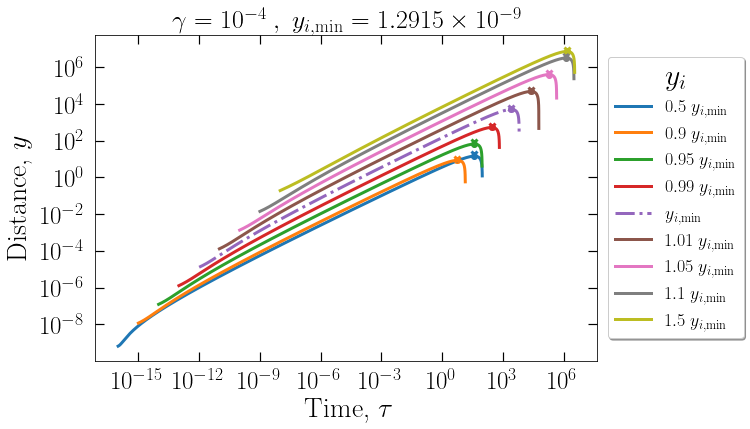

In [62]:
gamma = 1e-4
y_i_ref = 1.2915e-09
tau_i, tau_f = 1e-16, 1e15
gamma_values = np.geomspace(1e-10, 1, 5)

yi_arr = np.array([0.5*y_i_ref, 0.9*y_i_ref, 0.95*y_i_ref, 0.99*y_i_ref,  
                   y_i_ref, 1.01*y_i_ref, 1.05*y_i_ref, 1.1*y_i_ref, 1.5*y_i_ref])




fig, ax = plt.subplots(1, figsize = (9, 6))
plt.rc('lines', linewidth = 3)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')






colors = [ 'C0','C1','C2','C3','C4','C5', 'C6', 'C7', 'C8']

marker_handles = []
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])

    
    if i == 4:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$', ls ='-.')
    else:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$')

    
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        yta_analytic = r_turnaround_full(tauta_numerical, gamma)
        print( "y_i =", '%0.4e'%y_i , ",",  "tau_ta_numerical =", '%0.4e'%tauta_numerical, ",", "yta_numerical =", '%0.4e'%yta_numerical, ",", "yta_analytic =", '%0.4e'%yta_analytic)
            
        yta_numerical_marker = ax.scatter(tauta_numerical* (10**i), yta_numerical* (10**i),color=color, zorder=1  )
        yta_analytic_marker = ax.scatter(tauta_numerical* (10**i), yta_analytic* (10**i), color=color,  marker='x',  zorder=9)
        if i == 0:
            marker_handles.append((yta_numerical_marker, "Numerical "))
            marker_handles.append((yta_analytic_marker, "Analytic"))

if len(marker_handles) == 2:  
    legend1 = plt.legend(
        handles=[marker_handles[0][0], marker_handles[1][0]],
        labels=[marker_handles[0][1], marker_handles[1][1]],prop={'size':16.2},
        loc=(1.02, 0.58), title=r'$y_\mathrm{ta}$', title_fontsize= 29, fontsize=12)
    #ax.add_artist(legend1)


lines = ax.get_lines()
legend2 = plt.legend([lines[i] for i in range(len(colors))], 
        [r"$0.5 \;y_{i, \mathrm{min}}$", r"$0.9 \;y_{i, \mathrm{min}}$", r"$0.95\; y_{i, \mathrm{min}}$", 
        r"$0.99\; y_{i, \mathrm{min}}$" , r"$ y_{i, \mathrm{min}}$", 
        r"$1.01\; y_{i, \mathrm{min}}$", r"$1.05\; y_{i, \mathrm{min}}$",
        r"$1.1 \;y_{i, \mathrm{min}}$", r"$1.5 \;y_{i, \mathrm{min}}$"], prop={'size':18}, 
                     
                     loc=(1.02, 0.07), shadow=True, title='$y_{i}$', title_fontsize= 30,
    facecolor='white', fontsize=12)


ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)

#plt.text(tau_i, 1e-4, r'$\gamma = 3.6\times 10^{-5}$', fontsize = 25)
#plt.text(tau_i, 1e-6, r'$\tau_i = 10^{-28}$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28, labelpad=9)
plt.title(r'$\gamma = 10^{-4}\; , \; y_{i, \mathrm{min}} =  1.2915 \times 10^{-9}$', fontsize= 26)
plt.savefig('yta_min28.pdf', bbox_inches='tight')

plt.show()

y_i = 1.0772e-08 , tau_ta_numerical = 2.0064e+00 , yta_numerical = 2.0275e+00 , yta_analytic = 2.5236e+00
y_i = 1.9390e-08 , tau_ta_numerical = 1.1266e+00 , yta_numerical = 1.3927e+00 , yta_analytic = 1.7171e+00
y_i = 2.0467e-08 , tau_ta_numerical = 1.3078e+00 , yta_numerical = 1.5398e+00 , yta_analytic = 1.8967e+00
y_i = 2.1329e-08 , tau_ta_numerical = 1.4909e+00 , yta_numerical = 1.6816e+00 , yta_analytic = 2.0700e+00
y_i = 2.1544e-08 , tau_ta_numerical = 1.5426e+00 , yta_numerical = 1.7204e+00 , yta_analytic = 2.1176e+00
y_i = 2.1759e-08 , tau_ta_numerical = 1.5967e+00 , yta_numerical = 1.7607e+00 , yta_analytic = 2.1669e+00
y_i = 2.2621e-08 , tau_ta_numerical = 1.8395e+00 , yta_numerical = 1.9361e+00 , yta_analytic = 2.3815e+00
y_i = 2.3698e-08 , tau_ta_numerical = 2.2093e+00 , yta_numerical = 2.1890e+00 , yta_analytic = 2.6911e+00
y_i = 3.2316e-08 , tau_ta_numerical = 9.7942e+00 , yta_numerical = 5.9236e+00 , yta_analytic = 7.2649e+00


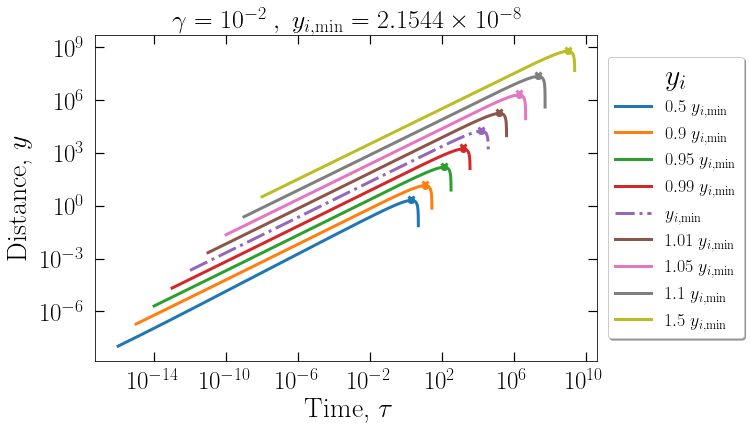

In [61]:
gamma = 1e-2
y_i_ref = 2.1544e-08
tau_i, tau_f = 1e-16, 1e15
gamma_values = np.geomspace(1e-10, 1, 5)

 
yi_arr = np.array([0.5*y_i_ref, 0.9*y_i_ref, 0.95*y_i_ref, 0.99*y_i_ref,  
                   y_i_ref, 1.01*y_i_ref, 1.05*y_i_ref, 1.1*y_i_ref, 1.5*y_i_ref])




fig, ax = plt.subplots(1, figsize = (9, 6))
plt.rc('lines', linewidth = 3)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')






colors = [ 'C0','C1','C2','C3','C4','C5', 'C6', 'C7', 'C8']

marker_handles = []
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])

    
    if i == 4:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$', ls ='-.')
    else:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$')

    
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        yta_analytic = r_turnaround_full(tauta_numerical, gamma)
        print( "y_i =", '%0.4e'%y_i , ",",  "tau_ta_numerical =", '%0.4e'%tauta_numerical, ",", "yta_numerical =", '%0.4e'%yta_numerical, ",", "yta_analytic =", '%0.4e'%yta_analytic)
            
        yta_numerical_marker = ax.scatter(tauta_numerical* (10**i), yta_numerical* (10**i),color=color, zorder=1  )
        yta_analytic_marker = ax.scatter(tauta_numerical* (10**i), yta_analytic* (10**i), color=color,  marker='x',  zorder=9)
        if i == 0:
            marker_handles.append((yta_numerical_marker, "Numerical "))
            marker_handles.append((yta_analytic_marker, "Analytic"))

if len(marker_handles) == 2:  
    legend1 = plt.legend(
        handles=[marker_handles[0][0], marker_handles[1][0]],
        labels=[marker_handles[0][1], marker_handles[1][1]],prop={'size':16.2},
        loc=(1.02, 0.58), title=r'$y_\mathrm{ta}$', title_fontsize= 29, fontsize=12)
    #ax.add_artist(legend1)


lines = ax.get_lines()
legend2 = plt.legend([lines[i] for i in range(len(colors))], 
        [r"$0.5 \;y_{i, \mathrm{min}}$", r"$0.9 \;y_{i, \mathrm{min}}$", r"$0.95\; y_{i, \mathrm{min}}$", 
        r"$0.99\; y_{i, \mathrm{min}}$" , r"$ y_{i, \mathrm{min}}$", 
        r"$1.01\; y_{i, \mathrm{min}}$", r"$1.05\; y_{i, \mathrm{min}}$",
        r"$1.1 \;y_{i, \mathrm{min}}$", r"$1.5 \;y_{i, \mathrm{min}}$"], prop={'size':18}, 
                     
                     loc=(1.02, 0.07), shadow=True, title='$y_{i}$', title_fontsize= 30,
    facecolor='white', fontsize=12)


ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)

#plt.text(tau_i, 1e-4, r'$\gamma = 3.6\times 10^{-5}$', fontsize = 25)
#plt.text(tau_i, 1e-6, r'$\tau_i = 10^{-28}$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28, labelpad=9)
plt.title(r'$\gamma = 10^{-2}\; , \; y_{i, \mathrm{min}} = 2.1544 \times 10^{-8}$', fontsize= 26)
plt.savefig('yta_min29.pdf', bbox_inches='tight')

plt.show()

y_i = 1.0772e-08 , tau_ta_numerical = 9.1080e+05 , yta_numerical = 1.2007e+04 , yta_analytic = 1.4915e+04
y_i = 1.9390e-08 , tau_ta_numerical = 1.7740e+04 , yta_numerical = 8.6844e+02 , yta_analytic = 1.0797e+03
y_i = 2.0467e-08 , tau_ta_numerical = 1.2507e+04 , yta_numerical = 6.8788e+02 , yta_analytic = 8.5523e+02
y_i = 2.1329e-08 , tau_ta_numerical = 9.6233e+03 , yta_numerical = 5.7758e+02 , yta_analytic = 7.1810e+02
y_i = 2.1544e-08 , tau_ta_numerical = 9.0318e+03 , yta_numerical = 5.5367e+02 , yta_analytic = 6.8836e+02
y_i = 2.1759e-08 , tau_ta_numerical = 8.4842e+03 , yta_numerical = 5.3106e+02 , yta_analytic = 6.6025e+02
y_i = 2.2621e-08 , tau_ta_numerical = 6.6636e+03 , yta_numerical = 4.5207e+02 , yta_analytic = 5.6203e+02
y_i = 2.3698e-08 , tau_ta_numerical = 5.0207e+03 , yta_numerical = 3.7433e+02 , yta_analytic = 4.6535e+02
y_i = 3.2316e-08 , tau_ta_numerical = 1.0129e+03 , yta_numerical = 1.2890e+02 , yta_analytic = 1.6002e+02


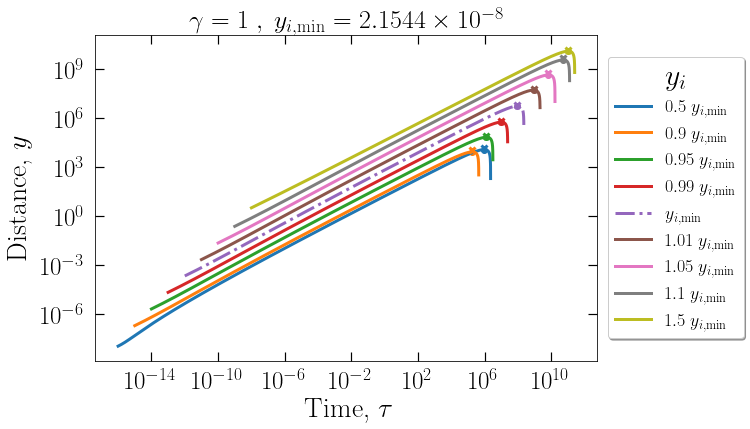

In [60]:
gamma = 1
y_i_ref = 2.1544e-08
tau_i, tau_f = 1e-16, 1e15
gamma_values = np.geomspace(1e-10, 1, 5)

yi_arr = np.array([0.5*y_i_ref, 0.9*y_i_ref, 0.95*y_i_ref, 0.99*y_i_ref,  
                   y_i_ref, 1.01*y_i_ref, 1.05*y_i_ref, 1.1*y_i_ref, 1.5*y_i_ref])




fig, ax = plt.subplots(1, figsize = (9, 6))
plt.rc('lines', linewidth = 3)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')






colors = [ 'C0','C1','C2','C3','C4','C5', 'C6', 'C7', 'C8']

marker_handles = []
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    v_i = y_i/(2 * tau_i) 
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])

    
    if i == 4:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$', ls ='-.')
    else:
        ax.loglog(sol_fdm.t* (10**i), sol_fdm.y[0]* (10**i), color=color, label=f' ${y_i:.4e}$')

    
    if len(sol_fdm.t_events[0]) > 0: 
        tauta_numerical = sol_fdm.t_events[0][0]
        yta_numerical = sol_fdm.y_events[0][0][0]
        yta_analytic = r_turnaround_full(tauta_numerical, gamma)
        print( "y_i =", '%0.4e'%y_i , ",",  "tau_ta_numerical =", '%0.4e'%tauta_numerical, ",", "yta_numerical =", '%0.4e'%yta_numerical, ",", "yta_analytic =", '%0.4e'%yta_analytic)
            
        yta_numerical_marker = ax.scatter(tauta_numerical* (10**i), yta_numerical* (10**i),color=color, zorder=1  )
        yta_analytic_marker = ax.scatter(tauta_numerical* (10**i), yta_analytic* (10**i), color=color,  marker='x',  zorder=9)
        if i == 0:
            marker_handles.append((yta_numerical_marker, "Numerical "))
            marker_handles.append((yta_analytic_marker, "Analytic"))

if len(marker_handles) == 2:  
    legend1 = plt.legend(
        handles=[marker_handles[0][0], marker_handles[1][0]],
        labels=[marker_handles[0][1], marker_handles[1][1]],prop={'size':16.2},
        loc=(1.02, 0.58), title=r'$y_\mathrm{ta}$', title_fontsize= 29, fontsize=12)
    #ax.add_artist(legend1)


lines = ax.get_lines()
legend2 = plt.legend([lines[i] for i in range(len(colors))], 
        [r"$0.5 \;y_{i, \mathrm{min}}$", r"$0.9 \;y_{i, \mathrm{min}}$", r"$0.95\; y_{i, \mathrm{min}}$", 
        r"$0.99\; y_{i, \mathrm{min}}$" , r"$ y_{i, \mathrm{min}}$", 
        r"$1.01\; y_{i, \mathrm{min}}$", r"$1.05\; y_{i, \mathrm{min}}$",
        r"$1.1 \;y_{i, \mathrm{min}}$", r"$1.5 \;y_{i, \mathrm{min}}$"], prop={'size':18}, 
                     
                     loc=(1.02, 0.07), shadow=True, title='$y_{i}$', title_fontsize= 30,
    facecolor='white', fontsize=12)


ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)

#plt.text(tau_i, 1e-4, r'$\gamma = 3.6\times 10^{-5}$', fontsize = 25)
#plt.text(tau_i, 1e-6, r'$\tau_i = 10^{-28}$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=28)
plt.ylabel('Distance, $y$', fontsize=28, labelpad=9)
plt.title(r'$\gamma = 1\; , \; y_{i, \mathrm{min}} = 2.1544 \times 10^{-8}$', fontsize= 26)
plt.savefig('yta_min30.pdf', bbox_inches='tight')

plt.show()